In this notebook we will use time series analysis to fit and train a model into SP500 index data. This work is organized as follow:

1) Data Exploration

2) Paramater Estimation and Residual Diagnostic

3) Forecasting

In [1]:
# Uncomment the lines bellow for installing packages
# %pip install fredapi

from fredapi import Fred
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10) #set default figure size
import numpy as np
import pandas as pd

# Data Exploration

First, we will collect the data and take its first difference

In [94]:
# FRED key
fred = Fred(api_key='7d98e730a7157daa810a101dcd13764a')

# Get SP500 data
data = fred.get_series('SP500', observation_start='2012-11-30', observation_end='2022-11-01',  
                       header=0, index_col=0, parse_dates=True)

In [95]:
# Data cleaning
data.replace([np.inf, -np.inf], np.nan)
SP500 = data.asfreq("d")
SP500 = data.interpolate()
SP500 = SP500.dropna()

# Creating the first difference Data
SP500_fdif = SP500.diff()
SP500_diff= SP500_fdif.dropna()

# SP500
# SP500_fdif

Now we combine in a DataFrame to plot them together

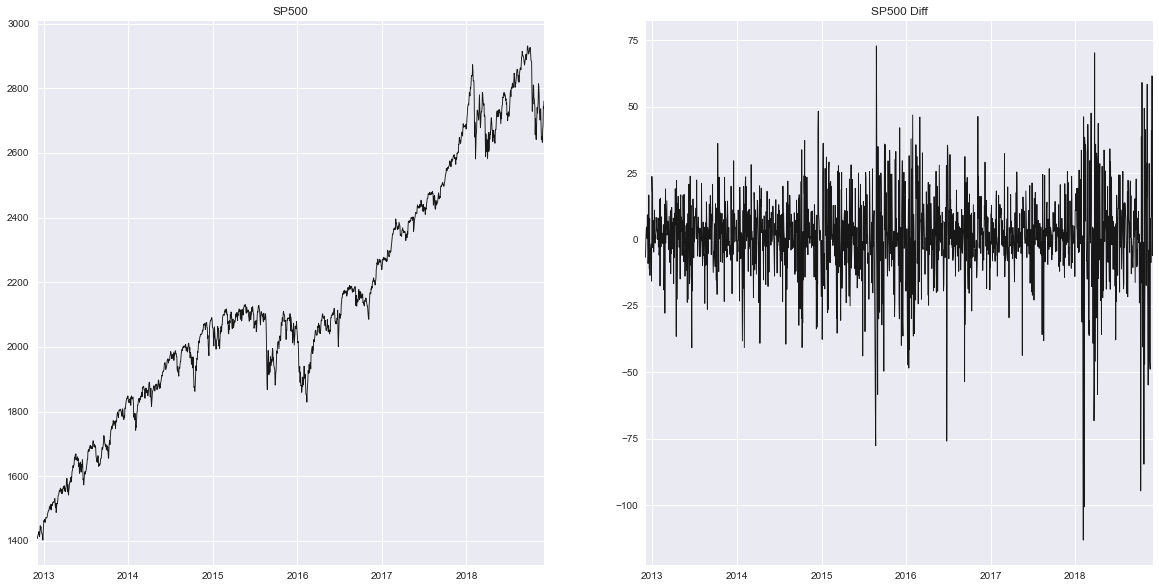

In [72]:
#We concatenate both serie in one DataFrame object to plot easily plot them together
plt.style.use('seaborn')
combineSP500 = pd.concat([SP500, SP500_fdif], axis=1)
combineSP500 = combineSP500.dropna()
combineSP500.plot(subplots = True, legend = False, layout = (1,2), figsize = (20,10), 
                  title = ["SP500", "SP500 Diff"], color = "black", linewidth = 0.9, alpha = 0.9)
plt.show()

From visual analysis we can see that there's a trend on the data, and thefore it's non-stionary. Taking the first difference seems to solve the problem. The values oscilates around zero and the variance looks constant during the whole period, even thoe there is some few spikes in some points. We can take a closer look into the data distribution by plotting the histogram and the density of both level and fist differenced data

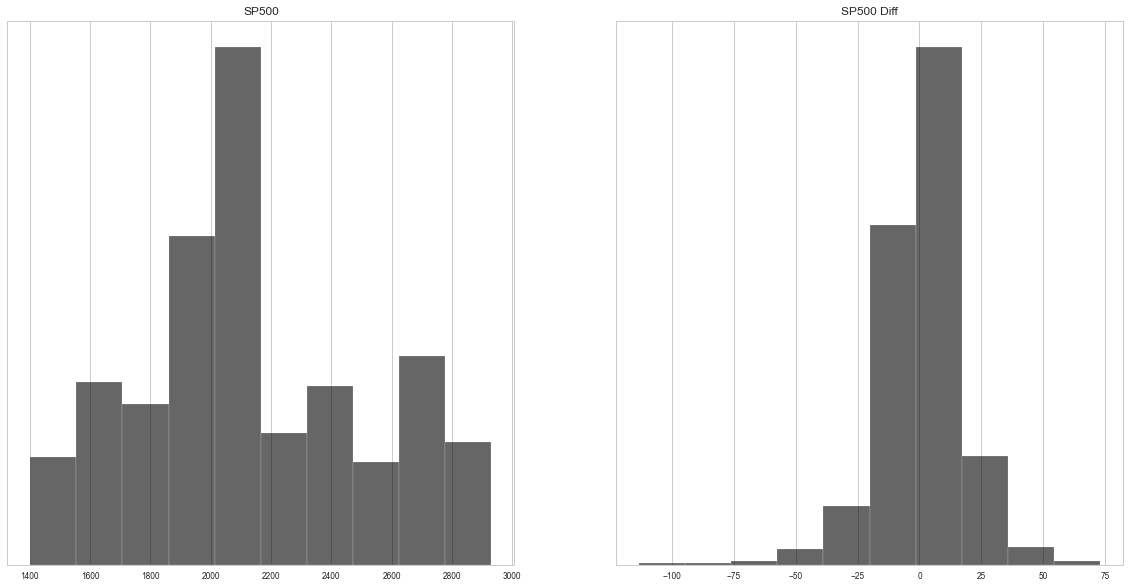

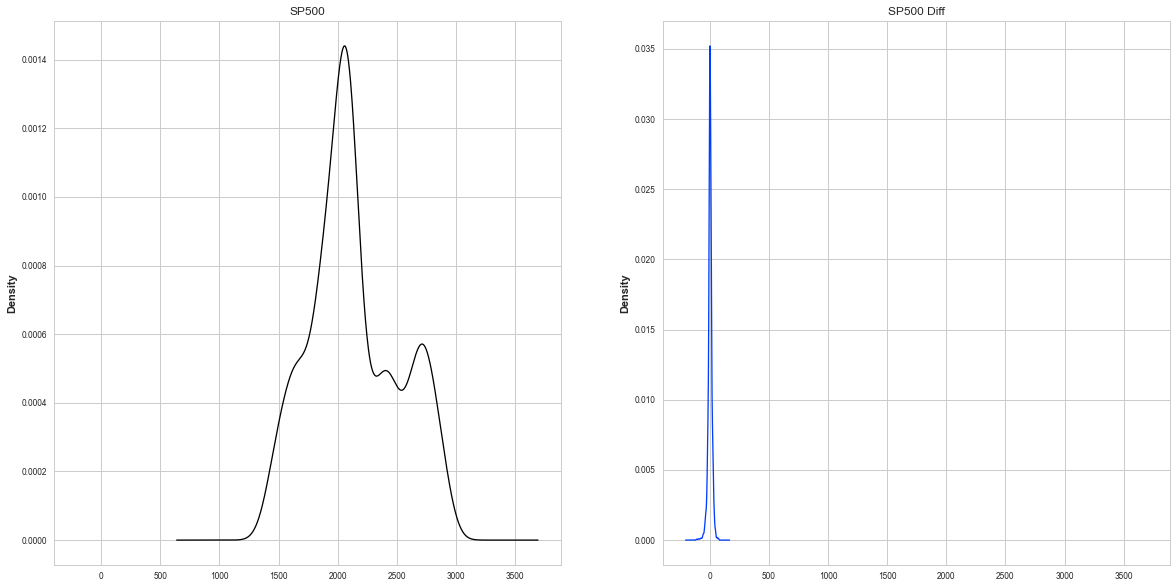

,SP500,SP500 diff
count,1566.000000,1565.000000
mean,2137.626916,0.858780
std,373.927078,16.613475
min,1402.430000,-113.190000
25%,1882.065000,-5.940000
50%,2081.385000,1.030000
75%,2415.632500,9.090000
max,2930.750000,72.900000
skew,0.294494,-0.800707
kurtosis,-0.680714,5.271700


In [184]:
# Histogram
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].hist(SP500, alpha=0.6)
axes[0].set(title = "SP500", yticks=[])
axes[1].hist(SP500_diff, alpha=0.6)
axes[1].set(title = "SP500 Diff", yticks=[])
plt.show()

# Density Distribution 
combineSP500.plot(subplots = True, kind="kde", legend= False, layout = (1,2), figsize = (20,10),
                  title = ["SP500", "SP500 Diff"])
plt.show()

descreptive = pd.DataFrame({"SP500": SP500.describe(), "SP500 diff": SP500_diff.describe()})
skew_kurtosis = pd.DataFrame({"SP500" : [SP500.skew(), SP500.kurtosis()],
                              "SP500 diff": [SP500_diff.skew(), SP500_diff.kurtosis()]},
                            index = ["skew", "kurtosis"])
statistics = pd.concat([descreptive, skew_kurtosis])
display(statistics)

From the histogram, the SP500 after first difference is the only one that closely resambles a normal distribution, only with some skew to the left and a lot of kurtosis. This is futher supported with the density plot with the distribution. 

Let's take a look at the lag scatter plot from the level and first difference series 

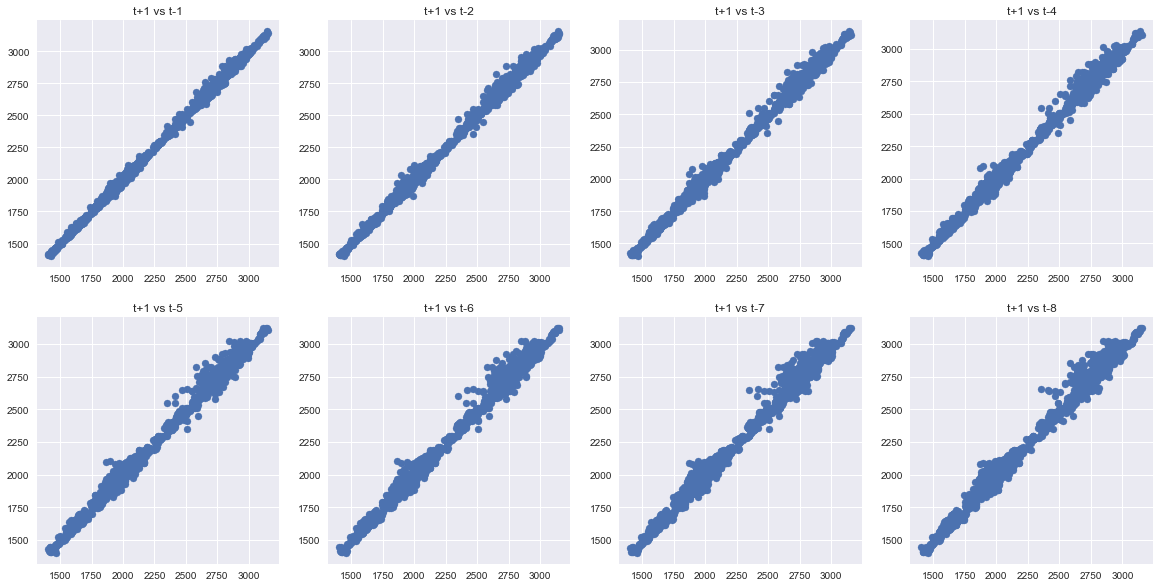

In [35]:
values = pd.DataFrame(SP500.values)
columns = [values]
lags = 8
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20,10))
lag_count = 1
for i in range(2):
    for j in range(4):
        axes[i,j].scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(lag_count)].values)
        axes[i,j].set(title = 't+1 vs t-' + str(lag_count))
        lag_count +=1
plt.show()

Over all, we can see a strong correlation in the level series with lag variables up to 8 lags

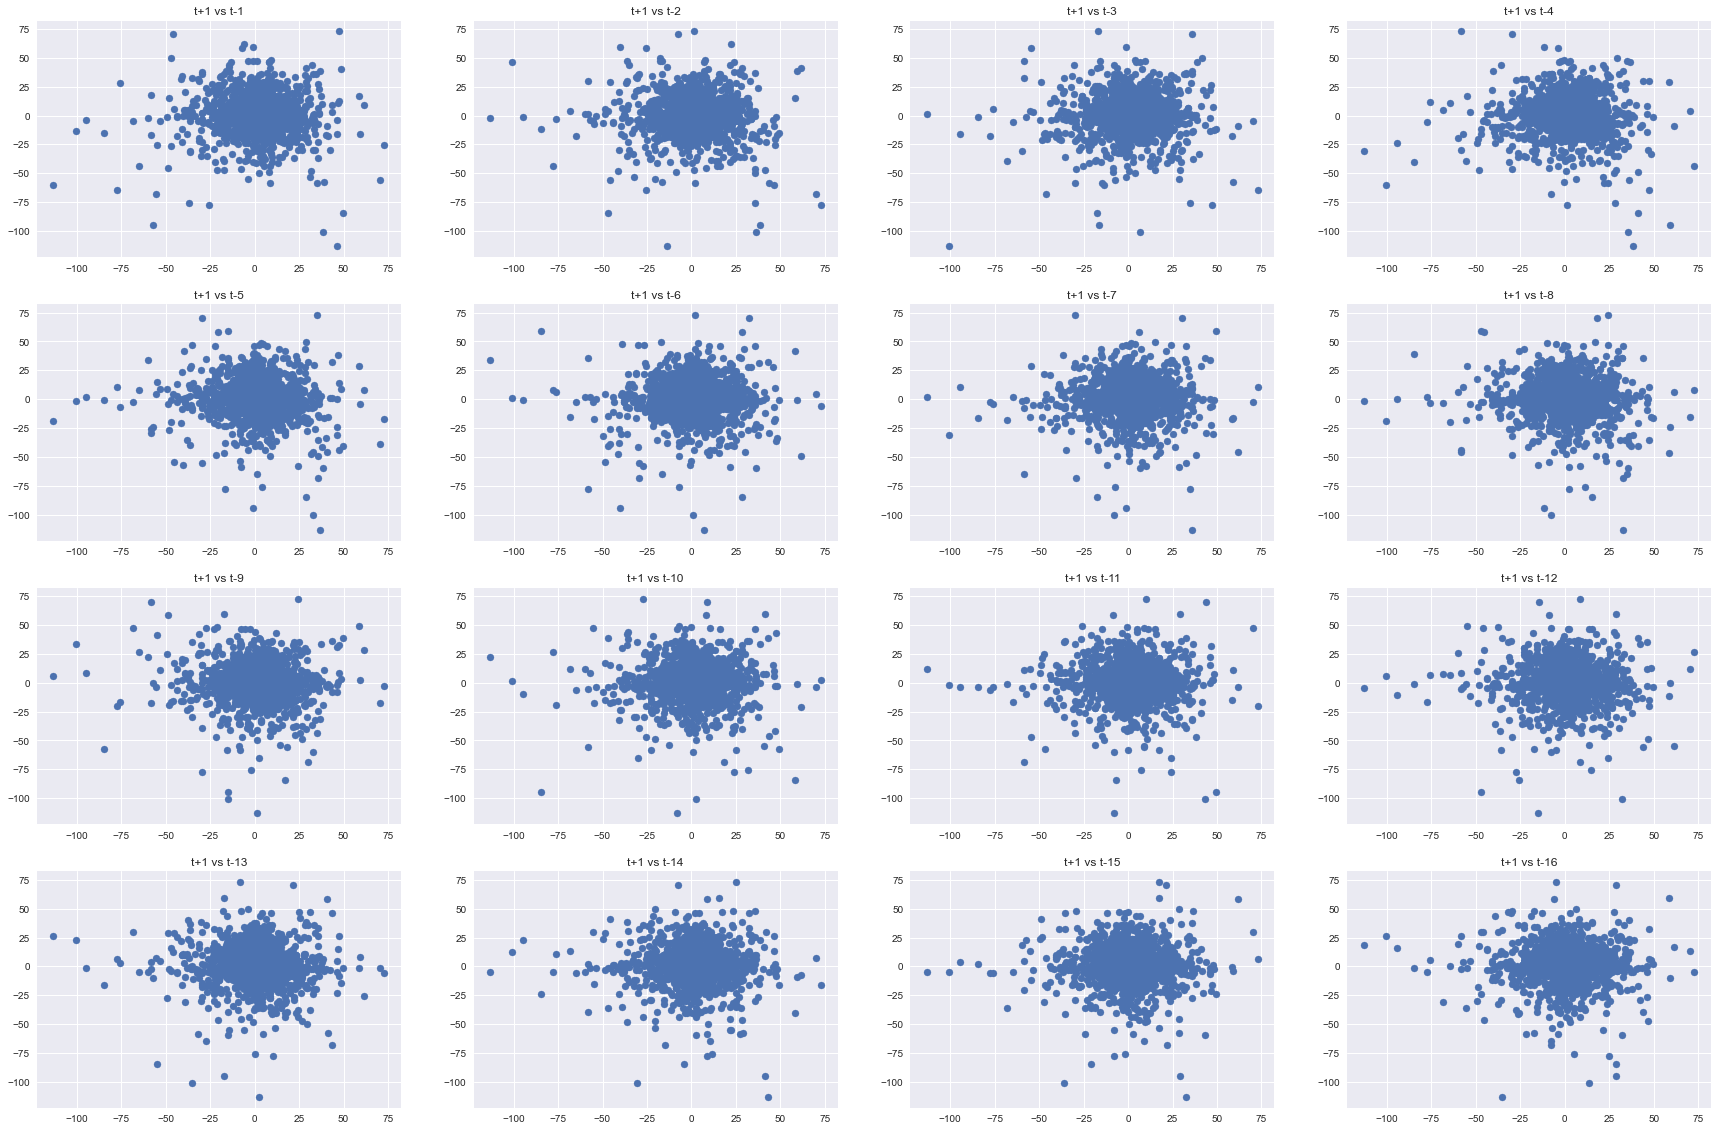

In [75]:
values = pd.DataFrame(SP500_diff.values)
columns = [values]
lags = 16
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
dataframe = pd.concat(columns, axis=1)
columns = ['t+1']
for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
dataframe.columns = columns
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (30,20))
lag_count = 1
for i in range(4):
    for j in range(4):
        axes[i,j].scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(lag_count)].values)
        axes[i,j].set(title = 't+1 vs t-' + str(lag_count))
        lag_count +=1
plt.show()

For the first difference data, the graphs show that there is little to no correlation between the change in value from one day to the next. Knowing the index value one day doesn’t tell us much about what it will do the next day. Now, let's take a look into the ACF and PACF plot for both series

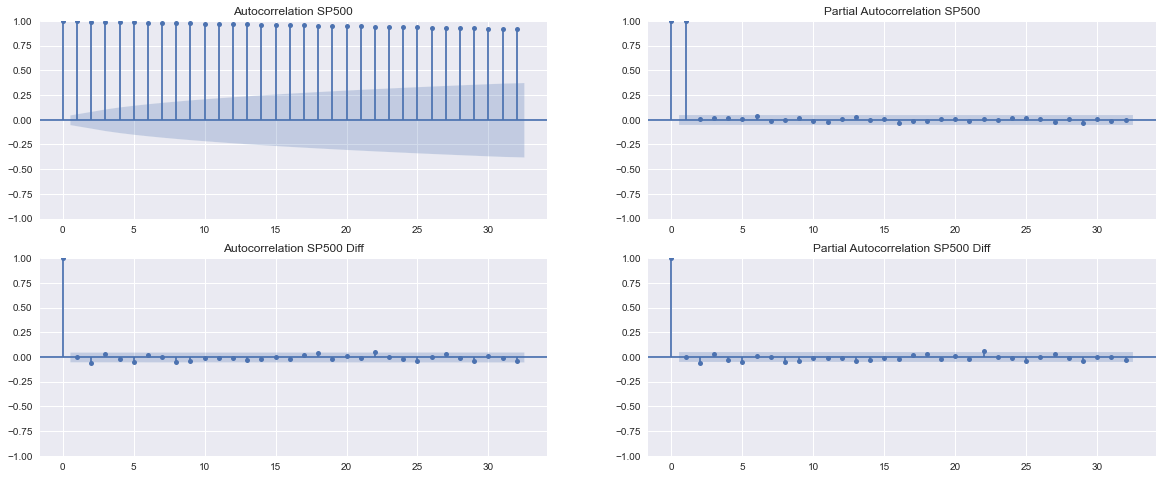

In [76]:
fig, ax = plt.subplots(nrows = 2, ncols =2, figsize = (20,8))
plot_acf(SP500, alpha=0.05,title='Autocorrelation SP500', ax=ax[0,0])
plot_pacf(SP500, method='ywm', title = "Partial Autocorrelation SP500", ax=ax[0,1])
plot_acf(SP500_diff, alpha=0.05, title='Autocorrelation SP500 Diff', ax=ax[1,0])
plot_pacf(SP500_diff, method='ywm', title = "Partial Autocorrelation SP500 Diff", ax=ax[1,1])
plt.show()

From the autocorrelation for the SP500 first difference, we can see significant correlation in lags up to 18 and 22. This provides evidence for the presence of of both conditional heteroskedasticity (i.e. volatility clustering) and long-memory effects. Therefore, we should include the GARCH model for a better fit to the data.

And we can make some decomposition of the time series to futher help with the forecast

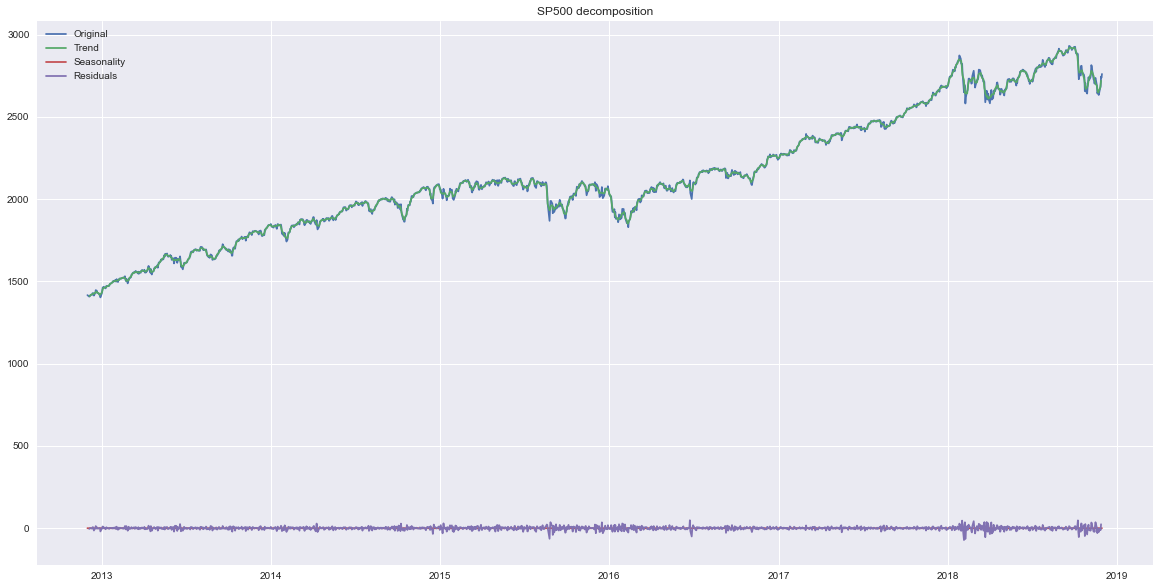

In [77]:
#Decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(SP500)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
 
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(SP500, label='Original')
ax.plot(trend, label='Trend')
ax.plot(seasonal, label='Seasonality')
ax.plot(residual, label='Residuals')
ax.legend()
ax.set_title('SP500 decomposition')
plt.show()

Decomposition using SciPy

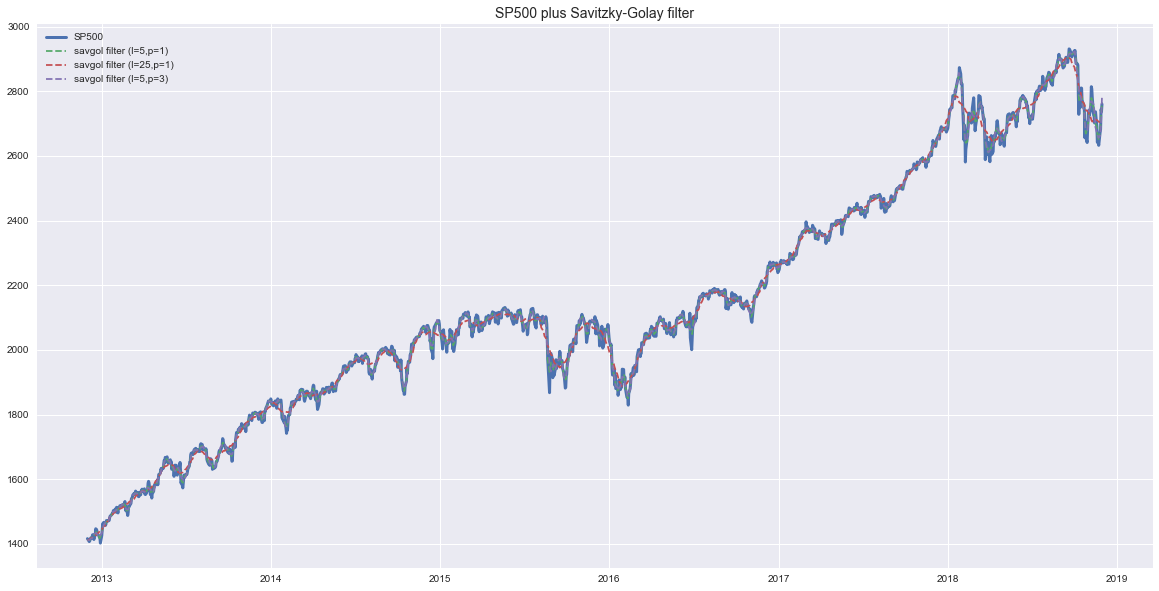

In [78]:
from scipy.signal import savgol_filter

yvalues = SP500.values
xvalues = SP500.index.values
yvalues_f_05_1 = savgol_filter(yvalues,5,1)
yvalues_f_15_3 = savgol_filter(yvalues,15,3)
yvalues_f_25_1 = savgol_filter(yvalues,25,1)

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(xvalues, yvalues, label='SP500',linewidth=3)
ax.plot(xvalues, yvalues_f_05_1, label='savgol filter (l=5,p=1)', linestyle='--')
ax.plot(xvalues, yvalues_f_25_1, label='savgol filter (l=25,p=1)', linestyle='--')
ax.plot(xvalues, yvalues_f_15_3, label='savgol filter (l=5,p=3)', linestyle='--')
ax.legend()
ax.set_title('SP500 plus Savitzky-Golay filter', fontsize=14)
plt.show()

Decomposition using pandas

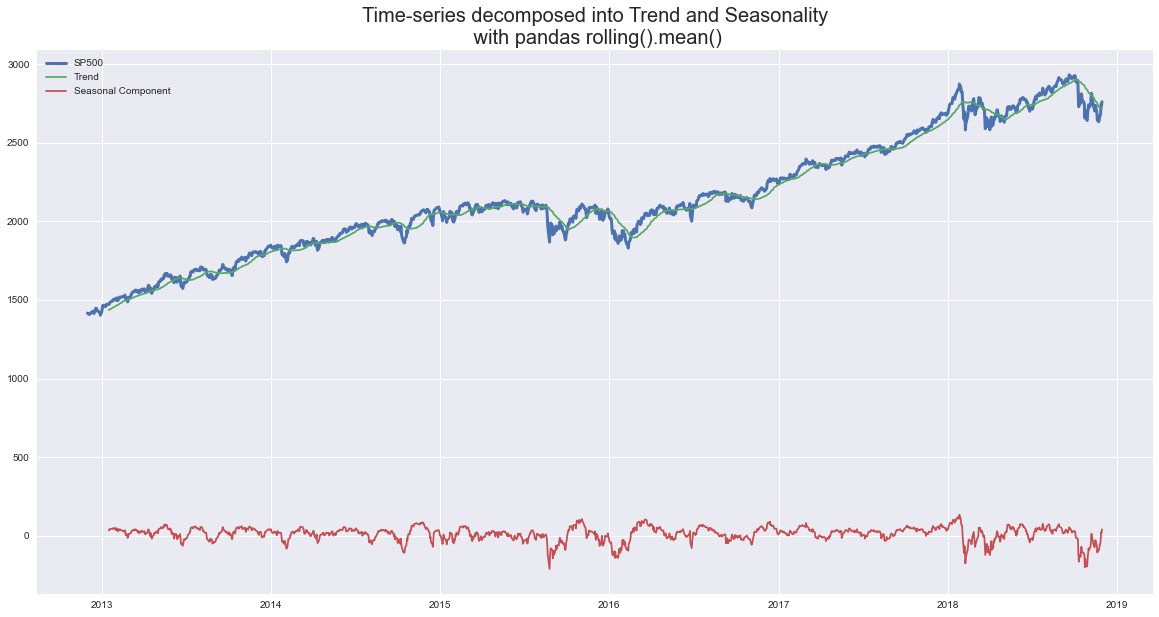

In [79]:
xvalues = SP500.index.values
yvalues = SP500.values
yvalues_trend = SP500.rolling(window=33).mean()
yvalues_detrended = yvalues - yvalues_trend

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(xvalues, yvalues, label='SP500',linewidth=3)
ax.plot(xvalues, yvalues_trend, label='Trend')
ax.plot(xvalues, yvalues_detrended, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with pandas rolling().mean()', fontsize=20)
plt.show()

In [27]:
#Dudek (2015) STDR decomposition
def STD_decomposition(data, period, is_reminder=False):
    """
    STD_decomposition - seasonal-trend-dispersion decomposition of time series

    data - time series, must be numpy array 1xN or Nx1
    period - length of the seasonal cycle
    is_reminder - 0 for STD (without reminder), 1 for STDR (with reminder)
    S - seasonal component, 1 x N
    T - trend component, 1 x N
    D - dispersion component, 1 x N
    R - reminder component, none for STD, 1 x N for STDR
    """
    #Checks if data argument satisfy the conditions
    if (type(data) != np.ndarray):
        return print("Data object must be a numpy array object of dimensions 1x50 or 50x1")
    
    y = data
    n = period
    N = len(data)
    K = int(N/n)
    
    if N%n != 0:
        return print("Length of the series " + str(N) + " should be a multiple of the seasonal period " + str(n) + ".")
    
    yy = y.reshape(n, K)
    
    #trend
    ym = np.mean(yy,0) 
    T = np.repeat(ym, n, axis = 0)

    #dispersion
    yd = np.std(yy,0)*(np.sqrt(n))
    D = np.repeat(yd, n, axis = 0)

    #seasonal for STD
    S = np.divide((y - T),D)

    #seasonal and reminder for STDR
    if is_reminder == True:
        q = S.reshape(n,K)
        sp = np.mean(q,1)
        sp = sp[...,None]
        S = np.repeat(sp, K, axis = 1)
        S = S.flatten()
        R = y - (np.multiply(S,D) + T) #reminder for STD
        return S, T, D, R  

    return S, T, D 

In [81]:
S, T, D, R = STD_decomposition(SP500.to_numpy(), 261, is_reminder= True)

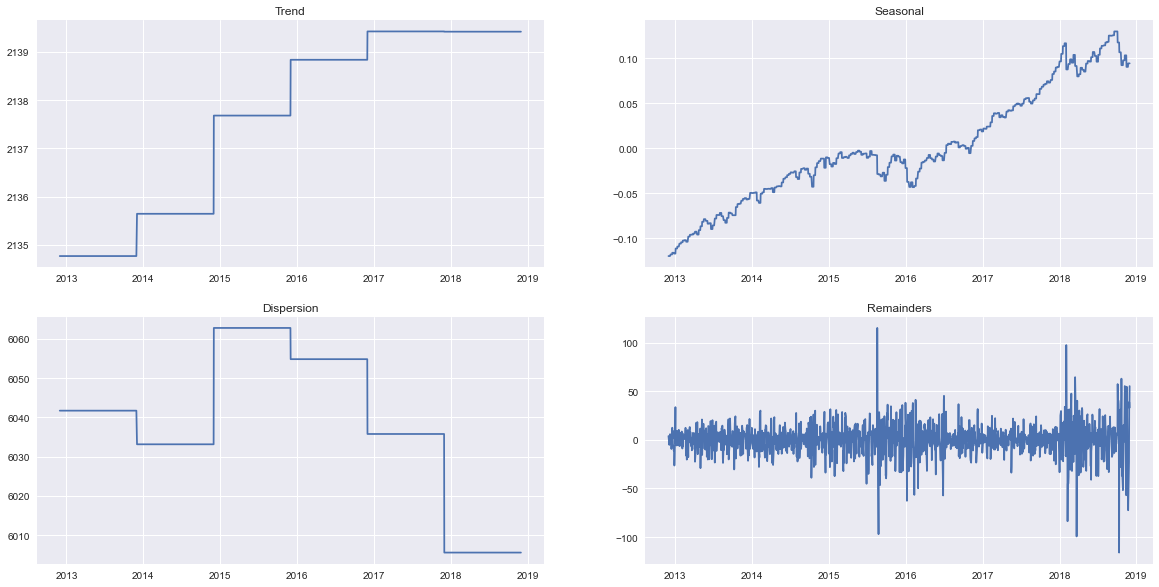

In [82]:
xvalues = SP500.index.values

fig, axes = plt.subplots(2,2, figsize=(20,10))
ax.plot(xvalues, yvalues, label='SP500',linewidth=3)
axes[0,0].plot(xvalues, T)
axes[0,0].set(title = "Trend")
axes[0,1].plot(xvalues, S)
axes[0,1].set(title = "Seasonal")
axes[1,0].plot(xvalues, D)
axes[1,0].set(title = "Dispersion")
axes[1,1].plot(xvalues, R)
axes[1,1].set(title = "Remainders")
plt.show()

Test for unit root

In [83]:
from arch.unitroot import ADF, KPSS, PhillipsPerron
adf_SP500 = ADF(SP500, trend = 'ct')
adf_SP500_diff = ADF(SP500_diff, trend = 'ct')
results = [adf_SP500.summary(),adf_SP500_diff.summary()] #use this to compare both results
results

[<class 'statsmodels.iolib.summary.Summary'>
 """
    Augmented Dickey-Fuller Results   
 Test Statistic                 -3.106
 P-value                         0.105
 Lags                                3
 -------------------------------------
 
 Trend: Constant and Linear Time Trend
 Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
    Augmented Dickey-Fuller Results   
 Test Statistic                -18.913
 P-value                         0.000
 Lags                                4
 -------------------------------------
 
 Trend: Constant and Linear Time Trend
 Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """]

In [84]:
kpss_SP500 = KPSS(SP500, trend = 'c')
kpss_SP500_diff = KPSS(SP500_diff, trend = 'c')
results = [kpss_SP500.summary(), kpss_SP500_diff.summary()] #use this to compare both results
results

[<class 'statsmodels.iolib.summary.Summary'>
 """
     KPSS Stationarity Test Results   
 Test Statistic                  5.518
 P-value                         0.000
 Lags                               25
 -------------------------------------
 
 Trend: Constant
 Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
 Null Hypothesis: The process is weakly stationary.
 Alternative Hypothesis: The process contains a unit root.
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
     KPSS Stationarity Test Results   
 Test Statistic                  0.044
 P-value                         0.910
 Lags                               13
 -------------------------------------
 
 Trend: Constant
 Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
 Null Hypothesis: The process is weakly stationary.
 Alternative Hypothesis: The process contains a unit root.
 """]

In [85]:
PP_SP500 = PhillipsPerron(SP500, trend = 'n')
PP_SP500_diff = PhillipsPerron(SP500_diff, trend = 'n')
results = [PP_SP500.summary(), PP_SP500_diff.summary()] #use this to compare both results
results

[<class 'statsmodels.iolib.summary.Summary'>
 """
      Phillips-Perron Test (Z-tau)    
 Test Statistic                  2.286
 P-value                         0.996
 Lags                               24
 -------------------------------------
 
 Trend: No Trend
 Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """,
 <class 'statsmodels.iolib.summary.Summary'>
 """
      Phillips-Perron Test (Z-tau)    
 Test Statistic                -39.977
 P-value                         0.000
 Lags                               24
 -------------------------------------
 
 Trend: No Trend
 Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
 Null Hypothesis: The process contains a unit root.
 Alternative Hypothesis: The process is weakly stationary.
 """]

# Fitting ARIMA-GARCH

First, we will start by grid searching the (p,d,q) parameters for ARIMA. We can easily do this with the auto_arima() function from the pmdarima package. This function selectes the best parameters based on the AIC criteria

In [106]:
# Taking log
SP500_log = np.log(SP500)
SP500_log

# Creating the first difference Data
SP500_fdif = SP500_log.diff()
SP500_diff= SP500_fdif.dropna()

In [107]:
import pmdarima

arima_model_fitted = pmdarima.auto_arima(SP500_diff.values)
arima_model_fitted

ARIMA(order=(0, 0, 2), scoring_args={}, suppress_warnings=True)

With the paramaters we can fit the ARIMA model and take a look at the residuals 

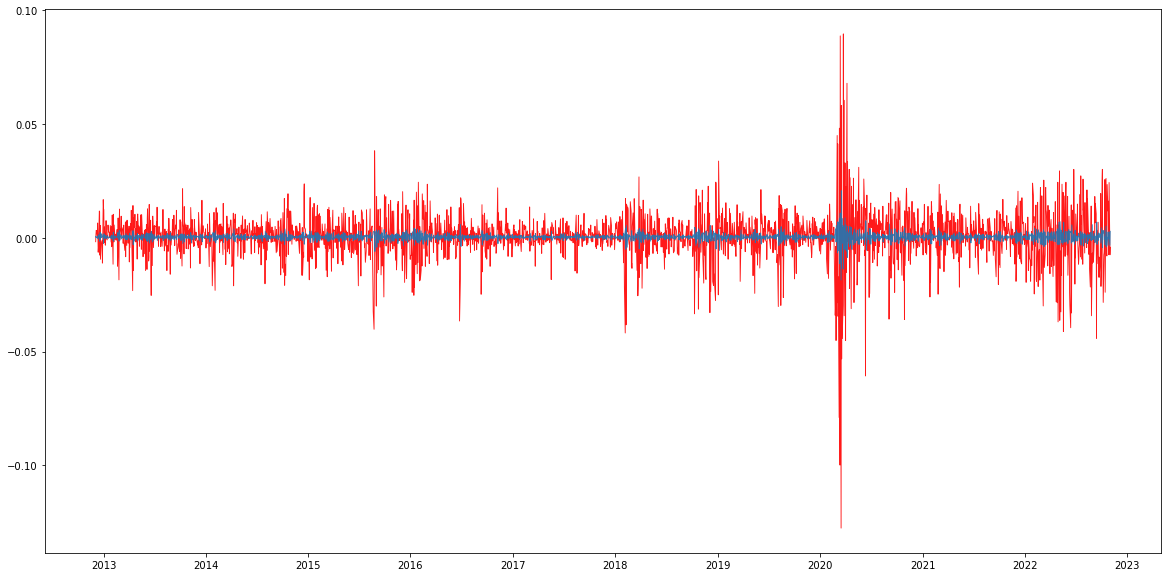

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2586
Model:                 ARIMA(0, 0, 2)   Log Likelihood                8084.474
Date:                Fri, 02 Dec 2022   AIC                         -16160.947
Time:                        09:46:49   BIC                         -16137.516
Sample:                    12-04-2012   HQIC                        -16152.455
                         - 11-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.788      0.074   -3.73e-05       0.001
ma.L1         -0.1267      0.008    -16.106      0.000      -0.142      -0.111
ma.L2          0.0835      0.007     12.082      0.0

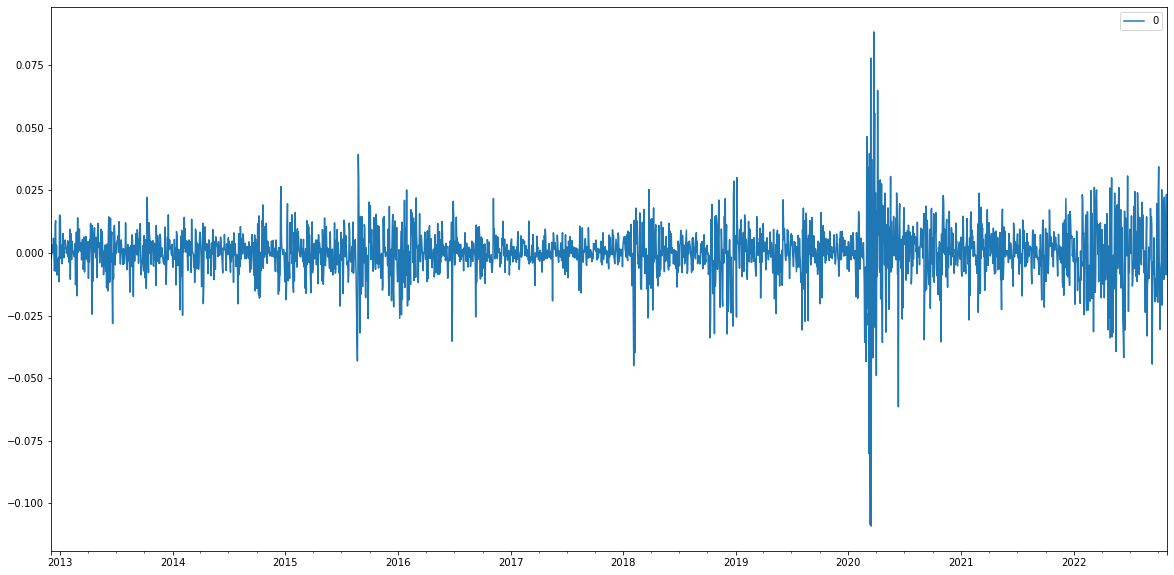

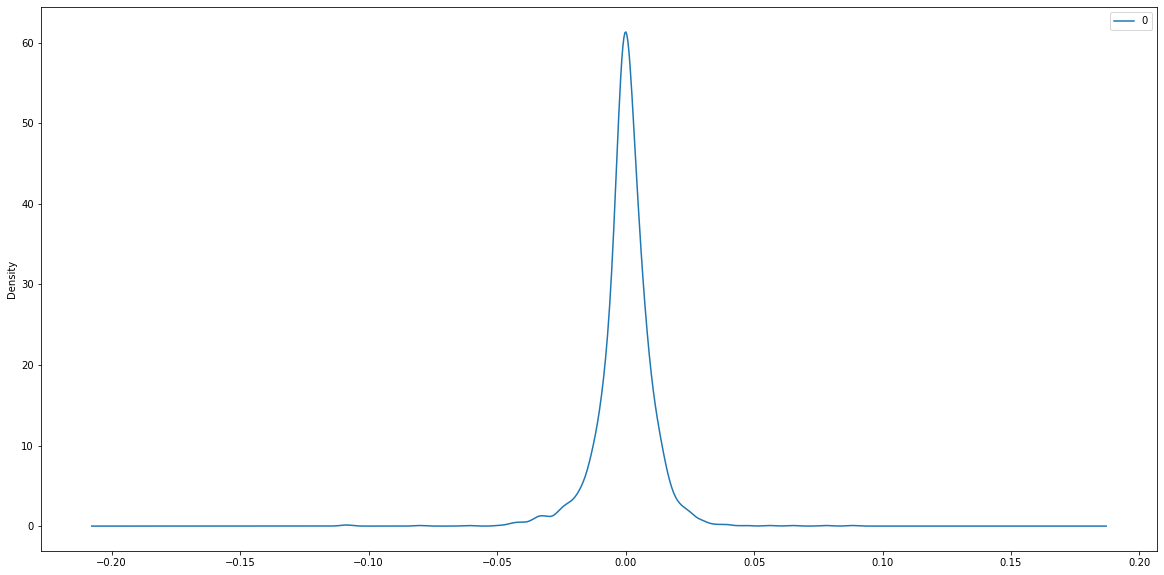

                 0
count  2586.000000
mean      0.000003
std       0.010620
min      -0.109097
25%      -0.003770
50%       0.000280
75%       0.004781
max       0.088347


In [108]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(SP500_diff, order = (0,0,2))
model_fit = model.fit()
plt.plot(SP500_diff, color = "red", linewidth = 0.9, alpha = 0.9)
plt.plot(model_fit.fittedvalues, linewidth = 0.9, alpha = 0.9)
plt.show()

#yhat = model_fit.predict(len(SP500_diff), len(SP500_diff), typ='levels')
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(label = "residuals")
plt.show()
# density plot of residuals
residuals.plot(kind='kde', label = "residuals distribution")
plt.show()
# summary stats of residuals
print(residuals.describe())

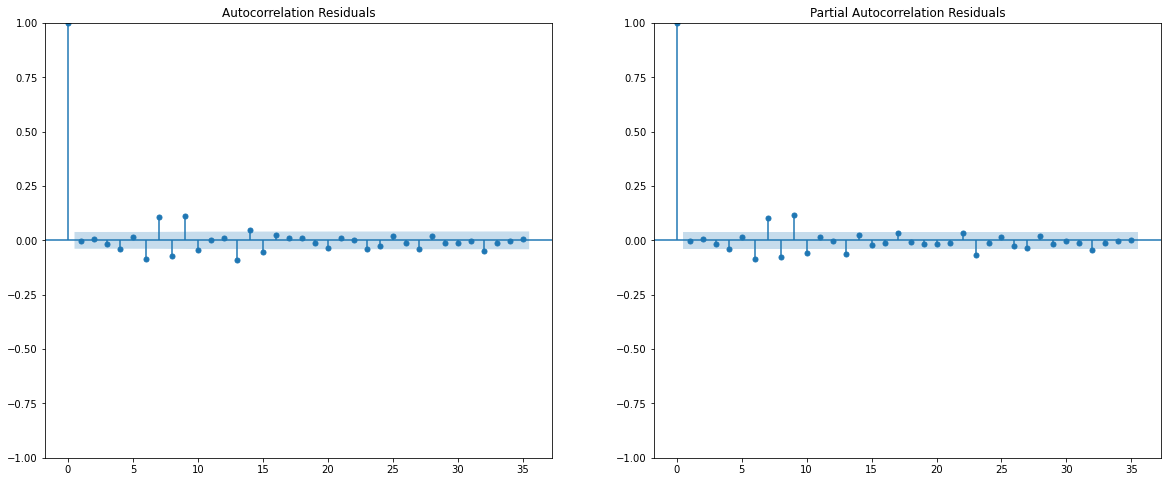

In [109]:
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (20,8))
plot_acf(residuals, alpha=0.05,title='Autocorrelation Residuals', ax=ax[0])
plot_pacf(residuals, method='ywm', title = "Partial Autocorrelation Residuals", ax=ax[1])
plt.show()

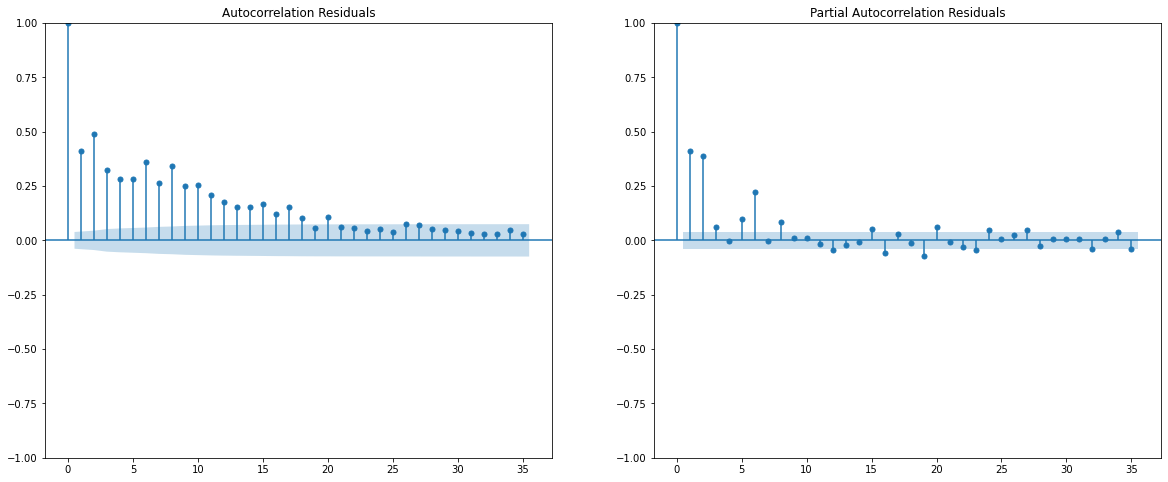

In [110]:
res_squares = np.square(residuals)
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (20,8))
plot_acf(res_squares, alpha=0.05,title='Autocorrelation Residuals', ax=ax[0])
plot_pacf(res_squares, method='ywm', title = "Partial Autocorrelation Residuals", ax=ax[1])
plt.show()

In [111]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
acorr_breusch_godfrey(model_fit)

(109.00764649419048,
 8.457390585437766e-19,
 11.33207736088725,
 3.246500905954492e-19)

ARCH-LM Test

In [112]:
from statsmodels.stats.diagnostic import het_arch
het_arch(model_fit.resid)

(879.0300753222168,
 2.0734311099789945e-182,
 132.8669477527485,
 5.120078517255568e-224)

In [113]:
#Grid Search for best GARCH(p,q) model
import arch 

results = pd.DataFrame(columns = ["GARCH(p,q)", "AIC", "Convergence"])
for q in range(0,3):
    for p in range(1, 11):
        garch = arch.arch_model(model_fit.resid, p=p, q=q)
        garch_fit = garch.fit()
        garch_aic = garch_fit.aic
        convergence = garch_fit.convergence_flag
        results = results.append({"GARCH(p,q)": f"GARCH({p},{q})", 
                                  "AIC": garch_aic,
                                  "Convergence": convergence}, ignore_index=True)


Iteration:      1,   Func. Count:      5,   Neg. LLF: 121691474895.63177
Iteration:      2,   Func. Count:     17,   Neg. LLF: 193337459030.89514
Iteration:      3,   Func. Count:     29,   Neg. LLF: 4.0815372504913575e+21
Iteration:      4,   Func. Count:     43,   Neg. LLF: 6.16194566086241e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8392.534044387372
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2918770372478.6265
Iteration:      2,   Func. Count:     19,   Neg. LLF: 529805.923510566
Iteration:      3,   Func. Count:     32,   Neg. LLF: 225664980.54317302
Iteration:      4,   Func. Count:     45,   Neg. LLF: 157264.29077274763
Iteration:      5,   Func. Count:     57,   Neg. LLF: 167845064.97165206
Iteration:      6,   Func. Count:     70,   Neg. LLF: 148965803.1928567
Optimization terminated successfully    (Exit mode 0)
     

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     13,   Neg. LLF: 79153326882.44283
Iteration:      2,   Func. Count:     33,   Neg. LLF: 2.2566183580433988e+16
Iteration:      3,   Func. Count:     55,   Neg. LLF: 1475650136376846.5
Iteration:      4,   Func. Count:     77,   Neg. LLF: 91599402195.93974
Iteration:      5,   Func. Count:     97,   Neg. LLF: 20093876616446.156
Iteration:      6,   Func. Count:    119,   Neg. LLF: 366697172.38804436
Iteration:      7,   Func. Count:    139,   Neg. LLF: 338723444202282.94
Iteration:      8,   Func. Count:    161,   Neg. LLF: 1.1472607259584842e+16
Iteration:      9,   Func. Count:    183,   Neg. LLF: 509582413236185.2
Iteration:     10,   Func. Count:    205,   Neg. LLF: 705262327.4462558
Iteration:     11,   Func. Count:    225,   Neg. LLF: 1593973.037137212
Iteration:     12,   Func. Count:    244,   Neg. LLF: 61151825545854.15
Iteration:     13,   Func. Count:    265,   Neg. LLF: -8650.516694386926
Optimization terminated successfully    (Exit mod

Iteration:      5,   Func. Count:     93,   Neg. LLF: 3.4907954562742607e+24
Iteration:      6,   Func. Count:    114,   Neg. LLF: 61322739724149.805
Iteration:      7,   Func. Count:    134,   Neg. LLF: 1.623455360103164e+20
Iteration:      8,   Func. Count:    155,   Neg. LLF: 47494911524789.984
Iteration:      9,   Func. Count:    172,   Neg. LLF: -4581.800949652545
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4581.800938849225
            Iterations: 13
            Function evaluations: 172
            Gradient evaluations: 9
Iteration:      1,   Func. Count:     13,   Neg. LLF: 51279125010.97234
Iteration:      2,   Func. Count:     33,   Neg. LLF: 3.1623006445761096e+18
Iteration:      3,   Func. Count:     55,   Neg. LLF: 107449437115769.08
Iteration:      4,   Func. Count:     77,   Neg. LLF: 50649110918.092354
Iteration:      5,   Func. Count:     97,   Neg. LLF: 76740793.68417333
Iteration:      6,   Func. Count:    117,   Neg. LL

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [114]:
results

,"GARCH(p,q)",AIC,Convergence
0,"GARCH(1,0)",-16779.068089,0
1,"GARCH(2,0)",-16959.00549,0
2,"GARCH(3,0)",-17043.110616,0
3,"GARCH(4,0)",-17064.592911,0
4,"GARCH(5,0)",-17042.627015,0
5,"GARCH(6,0)",-17058.486875,0
6,"GARCH(7,0)",-17046.638552,0
7,"GARCH(8,0)",-17026.123084,0
8,"GARCH(9,0)",-17026.831294,0
9,"GARCH(10,0)",-17015.696221,0


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.266166632233711e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.2773743197724408e+19
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8770.554439253752
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8770.554432420915
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8770.55
Distribution:                  Normal   AIC:                          -17533.1
Method:            Maximum Likelihood   BIC:                          -17509.7
                                        No. Observations:                 2586
Date:        

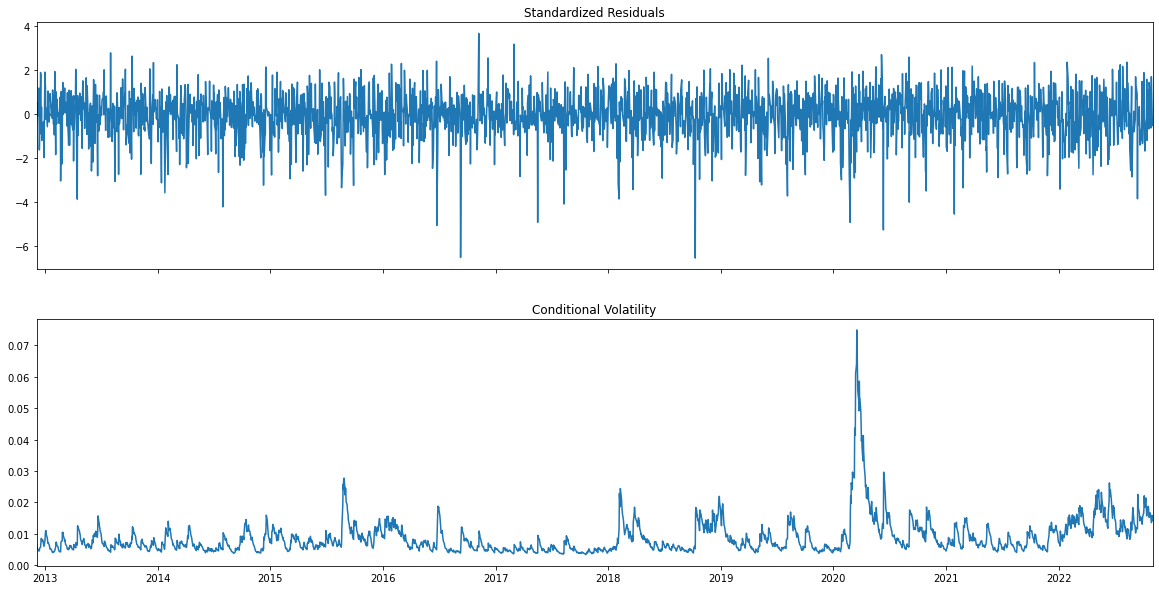

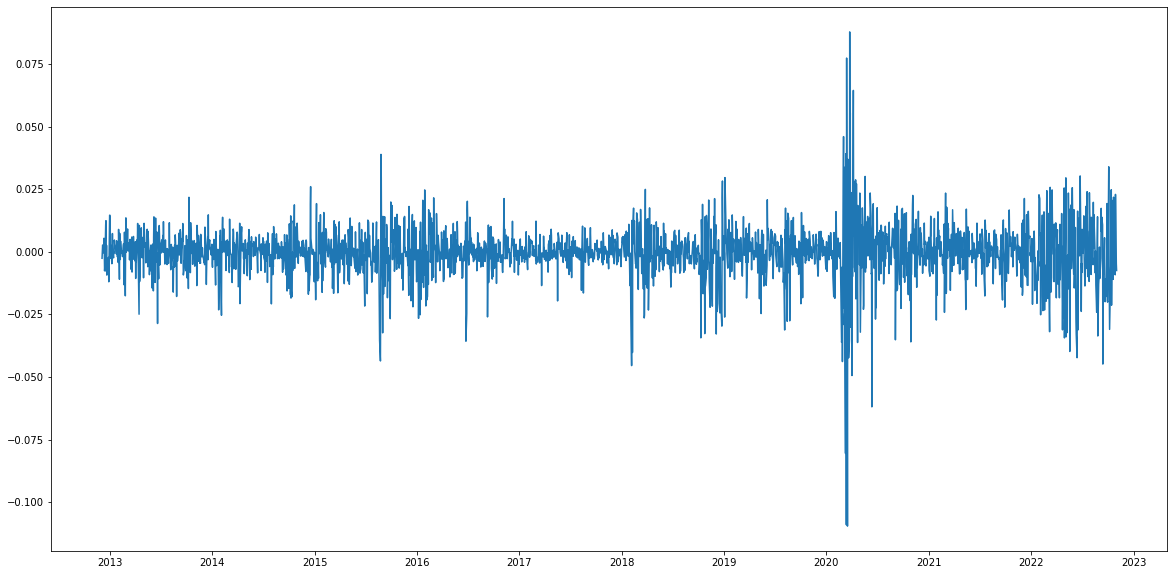

In [115]:
import arch 

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(model_fit.resid, p=1, q=1)
garch_fitted = garch.fit()
print(garch_fitted.summary())
garch_fitted.plot()
plt.show()
#plot residuals
plt.plot(garch_fitted.resid)
plt.show()

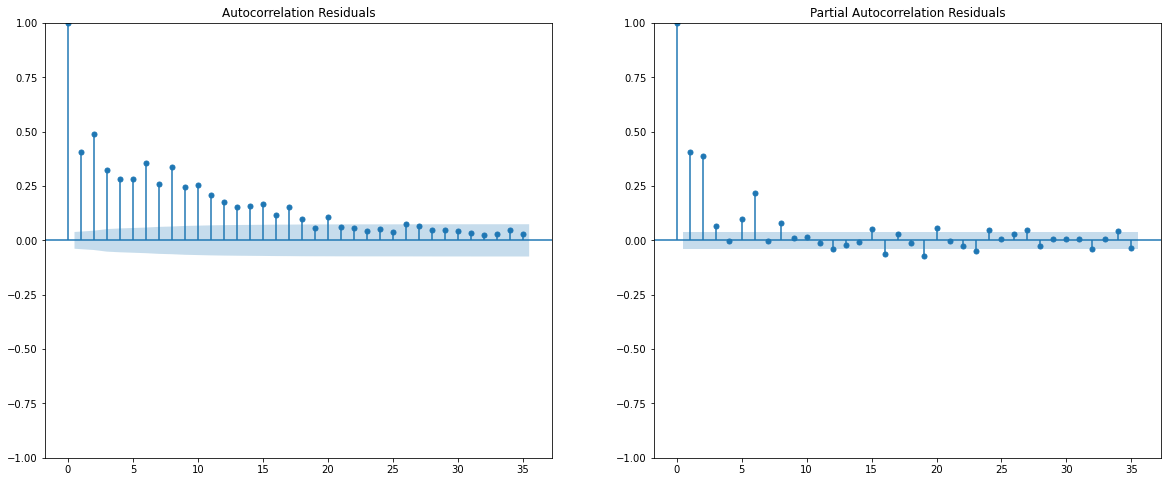

In [116]:
garch_squares = np.square(garch_fitted.resid)
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (20,8))
plot_acf(garch_squares, alpha=0.05,title='Autocorrelation Residuals', ax=ax[0])
plot_pacf(garch_squares, method='ywm', title = "Partial Autocorrelation Residuals", ax=ax[1])
plt.show()

# Forecasting

In [138]:
import arch 
def prepare_data_model(data, factor):
    """
    Split the data into train and test, and also initialize the lists
    that will be used to store the forecast values
    """
    X = data
    size = int(len(X) * factor)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = []
    y_lw= []
    y_up= []
    return train, test, history, predictions, y_lw, y_up

def ARIMA_GARCH(data, order, predictions, test, y_lw, y_up):
    #fit ARIMA and get mu
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast() 
    predicted_mu = forecast.predicted_mean[0] #get mean
    
    #fit garch from the arima residuals and get residuals
    garch = arch.arch_model(model_fit.resid, p=1, q=1)
    garch_fitted = garch.fit()
    predicted_et = garch_fitted.forecast().mean['h.1'].iloc[-1]
    y_l = predicted_mu -1.96*np.sqrt(garch_fitted.conditional_volatility[-1]) #lower band confidence interval
    y_u = predicted_mu +1.96*np.sqrt(garch_fitted.conditional_volatility[-1]) #upper band confidence interval
    
    #fitted value
    yhat = predicted_mu #mean from ARIMA
    
    #store results
    predictions.append(yhat)
    y_lw.append(y_l)
    y_up.append(y_u)
    obs = test[t]
    history.append(obs)
    print(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))

In [139]:
train, test, history, predictions, y_lw, y_up = prepare_data_model(SP500_diff.values, 0.8)

for t in range(len(test)):
    ARIMA_GARCH(history, (0,0,2), predictions, test, y_lw, y_up)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2798598412915062e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 277924.68977524503
Iteration:      3,   Func. Count:     31,   Neg. LLF: 735300200.3640224
Iteration:      4,   Func. Count:     44,   Neg. LLF: 7.340549769735157e+19
Iteration:      5,   Func. Count:     59,   Neg. LLF: 3.535250210254989e+19
Iteration:      6,   Func. Count:     74,   Neg. LLF: 9.818117985604985e+21
Iteration:      7,   Func. Count:     85,   Neg. LLF: 6.829783020526698e+22
Iteration:      8,   Func. Count:     98,   Neg. LLF: 7.906647706516813e+19
Iteration:      9,   Func. Count:    110,   Neg. LLF: 5432733609434.176
Iteration:     10,   Func. Count:    124,   Neg. LLF: 1.3594768670825114e+17
Iteration:     11,   Func. Count:    139,   Neg. LLF: 2.7876338576973455e+18
Iteration:     12,   Func. Count:    151,   Neg. LLF: -3587.6775522643757
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3587.67

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.268313114872983e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.2677821964716504e+17
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.664990617297037e+28
Iteration:      4,   Func. Count:     50,   Neg. LLF: 9.447035878868422e+21
Iteration:      5,   Func. Count:     61,   Neg. LLF: 359809409395189.44
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2.0758272428449822e+27
Iteration:      7,   Func. Count:     91,   Neg. LLF: 7.065020926935506e+21
Iteration:      8,   Func. Count:    102,   Neg. LLF: 7.054696941904032e+17
Iteration:      9,   Func. Count:    117,   Neg. LLF: 7.772002825899866e+21
Iteration:     10,   Func. Count:    128,   Neg. LLF: 949146732697805.4
Iteration:     11,   Func. Count:    143,   Neg. LLF: 1629478742211.8079
Iteration:     12,   Func. Count:    156,   Neg. LLF: -7125.685515197786
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7125.685

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2450940699947374e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7171.012516187898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7171.012511259037
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0017599647675565384
predicted=-0.001760, expected=-0.001586
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2487141499145703e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 23747.948212384104
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1.043365082698915e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.8954789293455175e+21
Iteration:      5,   Func. Count:     61,   Neg. LLF: 1.2061707658132367e+20
Iteration:      6,   Func. Count:     75,   Neg. LLF: 3.0354954680172204e+19
Iteration:      7,   Func. Count:     89,   Neg. LLF: 4.974936829687548e+23
Iteration:      8,   Func. Count:    104,   Ne

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2578844437159497e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7223.38684908799
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7223.386844335555
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0010450532213830252
predicted=0.001045, expected=0.012838
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2904934373999606e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.766954442006695e+16
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.0808139461647783e+28
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1127366921909806.2
Iteration:      5,   Func. Count:     63,   Neg. LLF: 4.564087308742793e+22
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.6671775287999667e+17
Iteration:      7,   Func. Count:     91,   Neg. LLF: 187259027078.28345
Iteration:      8,   Func. Count:    102,   Neg. LLF: 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3133990772785002e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.383534223445178e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7261.483769468462
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2
0.0003212344323522988
predicted=0.000321, expected=-0.002230
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.316116193214391e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.466709847837338e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7265.665740310053
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2
0.0013658852914731243
predicted=0.001366, expected=0.001341
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3207996738788244e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.069556053988356e+16
Optim

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.31119034025557e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.9541984256784732e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5.451432179277464e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.1762430787853127e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 9367922303090.906
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.1110375529350244e+23
Iteration:      7,   Func. Count:     92,   Neg. LLF: -6877.93155964265
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6877.931543892324
            Iterations: 11
            Function evaluations: 92
            Gradient evaluations: 7
-1.8804319883020115e-05
predicted=-0.000019, expected=0.014738
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2924532625520166e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.739286122841452e+17
Iteration:      3,   Func. Count:     35,   Neg. 

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.285134961867613e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 212888.72769625502
Iteration:      3,   Func. Count:     31,   Neg. LLF: 576500974.5385163
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1.1580829060037838e+21
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1.8390901597304856e+16
Iteration:      6,   Func. Count:     74,   Neg. LLF: 1.9164917538548793e+22
Iteration:      7,   Func. Count:     86,   Neg. LLF: 7.026704786676767e+17
Iteration:      8,   Func. Count:    101,   Neg. LLF: 1.5272129931222102e+21
Iteration:      9,   Func. Count:    115,   Neg. LLF: 3.7738785197245204e+23
Iteration:     10,   Func. Count:    129,   Neg. LLF: -5503.263564132294
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5503.2635500802935
            Iterations: 14
            Function evaluations: 129
            Gradient evaluations: 10
0.0011956505321809347
predicted=0

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3070735016639817e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.7056306355161992e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.1972246519314504e+27
Iteration:      4,   Func. Count:     50,   Neg. LLF: 117020361666.93227
Iteration:      5,   Func. Count:     61,   Neg. LLF: 5.158198197686359e+28
Iteration:      6,   Func. Count:     76,   Neg. LLF: 8.372026944643712e+21
Iteration:      7,   Func. Count:     87,   Neg. LLF: 3.200352406906916e+23
Iteration:      8,   Func. Count:    102,   Neg. LLF: 1.412007177895182e+18
Iteration:      9,   Func. Count:    117,   Neg. LLF: 17187426775360.057
Iteration:     10,   Func. Count:    131,   Neg. LLF: 6363078844708.325
Iteration:     11,   Func. Count:    145,   Neg. LLF: -5549.503164110531
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5549.503148096326
            Iterations: 15
            Function evaluations: 145


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 215872798599.87653
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7335.732895215283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7335.732889371648
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0036088989372310832
predicted=0.003609, expected=0.015924
Iteration:      1,   Func. Count:      6,   Neg. LLF: 211121967438.87286
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.050925812896709e+17
Iteration:      3,   Func. Count:     35,   Neg. LLF: 7.435274479367215e+22
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.288078812402551e+20
Iteration:      5,   Func. Count:     65,   Neg. LLF: 12437036702411.195
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4.59068472804601e+21
Iteration:      7,   Func. Count:     93,   Neg. LLF: 5.351478227523956e+20
Iteration:      8,   Func. Count:    106,   Neg. LLF: 8.38127

Iteration:      1,   Func. Count:      6,   Neg. LLF: 202131896694.50772
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.68584967996577e+19
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4.053066237788302e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 4628493410034.151
Iteration:      5,   Func. Count:     65,   Neg. LLF: 10405975290321.695
Iteration:      6,   Func. Count:     80,   Neg. LLF: 8.394005688064984e+16
Iteration:      7,   Func. Count:     95,   Neg. LLF: 1804221951094.9106
Iteration:      8,   Func. Count:    109,   Neg. LLF: 7.232307873379548e+28
Iteration:      9,   Func. Count:    124,   Neg. LLF: 1.6771551532725885e+18
Iteration:     10,   Func. Count:    138,   Neg. LLF: 7677739051273615.0
Iteration:     11,   Func. Count:    153,   Neg. LLF: 35766031794612.016
Iteration:     12,   Func. Count:    164,   Neg. LLF: -2299.2474894738034
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2299.247480126107


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2063976142719183e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1534700806581624e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 6.083361589107936e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1124011120914776.2
Iteration:      5,   Func. Count:     65,   Neg. LLF: 7.877085800939393e+25
Iteration:      6,   Func. Count:     80,   Neg. LLF: 992051836000569.1
Iteration:      7,   Func. Count:     93,   Neg. LLF: 34042603826466.15
Iteration:      8,   Func. Count:    106,   Neg. LLF: 5.977853602721909e+21
Iteration:      9,   Func. Count:    121,   Neg. LLF: 108079957953694.39
Iteration:     10,   Func. Count:    133,   Neg. LLF: 2213382378414.1797
Iteration:     11,   Func. Count:    147,   Neg. LLF: 8.137928681781757e+17
Iteration:     12,   Func. Count:    162,   Neg. LLF: 7.156126294741596e+21
Iteration:     13,   Func. Count:    173,   Neg. LLF: 5.987019124380756e+20
Iteration:     14,   Func. 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2300741930595115e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.9273251614968626e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4.000498468852995e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 19089125076646.926
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6955830740288.061
Iteration:      6,   Func. Count:     80,   Neg. LLF: 2.6111715568573703e+23
Iteration:      7,   Func. Count:     95,   Neg. LLF: 2.6392958206702904e+18
Iteration:      8,   Func. Count:    110,   Neg. LLF: 5.733562786631393e+21
Iteration:      9,   Func. Count:    119,   Neg. LLF: -1428.0463797584657
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1428.046369703411
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9
0.005613358941815141
predicted=0.005613, expected=-0.004761
Iteration:      1,   Func. Count:      6,   Neg. LL

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.232076725099788e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.399794923556875e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.403047476066178e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.6728049459427897e+26
Iteration:      5,   Func. Count:     65,   Neg. LLF: 323169356394.1877
Iteration:      6,   Func. Count:     77,   Neg. LLF: 3.6908581476858995e+25
Iteration:      7,   Func. Count:     92,   Neg. LLF: 28010478134920.855
Iteration:      8,   Func. Count:    104,   Neg. LLF: 1.7676848524180951e+19
Iteration:      9,   Func. Count:    119,   Neg. LLF: 21727763846206.19
Iteration:     10,   Func. Count:    132,   Neg. LLF: 1.1341577449702362e+23
Iteration:     11,   Func. Count:    146,   Neg. LLF: 9.22202173830607e+17
Iteration:     12,   Func. Count:    160,   Neg. LLF: 113.02357999305471
Optimization terminated successfully    (Exit mode 0)
            Current function value: 113.02359

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2222901547661437e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.0296967563643541e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4.417073753878719e+17
Iteration:      4,   Func. Count:     50,   Neg. LLF: 5.117198021155803e+24
Iteration:      5,   Func. Count:     62,   Neg. LLF: 1296124162546.0818
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.037284959070182e+21
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1539607874285079.0
Iteration:      8,   Func. Count:    102,   Neg. LLF: 2.448350366782522e+19
Iteration:      9,   Func. Count:    117,   Neg. LLF: 5.891382178364145e+21
Iteration:     10,   Func. Count:    127,   Neg. LLF: 8.007900188559026e+18
Iteration:     11,   Func. Count:    142,   Neg. LLF: 1.638930266291819e+23
Iteration:     12,   Func. Count:    156,   Neg. LLF: 4.65518908359182e+21
Iteration:     13,   Func. Count:    170,   Neg. LLF: 6.074385262617912e+23
Iteration:     14

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2318494933585039e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1691430586729384e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 6.215355128831228e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.840688020185326e+22
Iteration:      5,   Func. Count:     64,   Neg. LLF: 2.6245874001971717e+18
Iteration:      6,   Func. Count:     79,   Neg. LLF: 2.680809500027008e+22
Iteration:      7,   Func. Count:     92,   Neg. LLF: 2.493713545385883e+17
Iteration:      8,   Func. Count:    107,   Neg. LLF: 1.0527990719777167e+22
Iteration:      9,   Func. Count:    117,   Neg. LLF: -4002.037060262418
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4002.0370503421927
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 9
0.0009829805055640156
predicted=0.000983, expected=0.005227
Iteration:      1,   Func. Count:      6,   

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2315047421718011e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.7630337389916354e+26
Iteration:      3,   Func. Count:     35,   Neg. LLF: 8.408266182724099e+21
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.401106495958344e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7474.752029927139
            Iterations: 6
            Function evaluations: 58
            Gradient evaluations: 4
-0.0004922474416603395
predicted=-0.000492, expected=0.011756
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2172961423816147e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.07830729011824e+28
Iteration:      3,   Func. Count:     35,   Neg. LLF: 10664196341226.812
Iteration:      4,   Func. Count:     50,   Neg. LLF: 3758129775002267.0
Iteration:      5,   Func. Count:     65,   Neg. LLF: 3.7973742725246367e+18
Iteration:      6,   Func. Count:     80,   Neg. 

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2080543883827975e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.9781808398137203e+25
Iteration:      3,   Func. Count:     35,   Neg. LLF: 9.034739572598253e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4907400206572006.0
Iteration:      5,   Func. Count:     63,   Neg. LLF: 6.424352785023783e+20
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.4237591849604975e+19
Iteration:      7,   Func. Count:     91,   Neg. LLF: 6.281529906290237e+23
Iteration:      8,   Func. Count:    106,   Neg. LLF: 9.734172992231421e+22
Iteration:      9,   Func. Count:    119,   Neg. LLF: -7484.584328210558
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7484.584322535432
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9
0.0014539110025613275
predicted=0.001454, expected=0.001474
Iteration:      1,   Func. Count:      6,   Neg. 

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.231923502366641e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.08767681465352e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 6860679833966.396
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.9909243892294807e+23
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6.270525624959869e+23
Iteration:      6,   Func. Count:     80,   Neg. LLF: 5.7561426098498715e+22
Iteration:      7,   Func. Count:     94,   Neg. LLF: 1.8699328111552504e+19
Iteration:      8,   Func. Count:    109,   Neg. LLF: 4.5403509968965074e+18
Iteration:      9,   Func. Count:    122,   Neg. LLF: -2715.915111288066
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2715.915102189244
            Iterations: 13
            Function evaluations: 122
            Gradient evaluations: 9
0.00019812343819792128
predicted=0.000198, expected=-0.004096
Iteration:      1,   Func. Count:      6,   Neg.

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2354694313070027e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7518.556472589424
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7518.556466793296
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0007761740279801862
predicted=0.000776, expected=-0.005321
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2390809191806145e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.210266284177266e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.2312188900955206e+17
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.0735785405198027e+27
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.2681034830959081e+22
Iteration:      6,   Func. Count:     74,   Neg. LLF: 653903265667.135
Iteration:      7,   Func. Count:     87,   Neg. LLF: 3.999361554341342e+23
Iteration:      8,   Func. Count:    102,   Neg. L

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2430741549601964e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.4746361664300794e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.8161365563809843e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.0225863355756223e+20
Iteration:      5,   Func. Count:     65,   Neg. LLF: 7.141421547720488e+21
Iteration:      6,   Func. Count:     80,   Neg. LLF: 3291222016326.265
Iteration:      7,   Func. Count:     95,   Neg. LLF: 3.0729216421294333e+21
Iteration:      8,   Func. Count:    108,   Neg. LLF: 1.5243019802979014e+17
Iteration:      9,   Func. Count:    123,   Neg. LLF: 1.058449786107154e+30
Iteration:     10,   Func. Count:    138,   Neg. LLF: 6.243476165392014e+21
Iteration:     11,   Func. Count:    147,   Neg. LLF: -2844.8288337107497
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2844.8288240326056
            Iterations: 15
            Function evalua

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2478898485177528e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 4.842263647530129e+27
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.3886475159183636e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 3.1108005016739275e+23
Iteration:      5,   Func. Count:     65,   Neg. LLF: 3.892431052998101e+18
Iteration:      6,   Func. Count:     80,   Neg. LLF: 1.4138734755096145e+33
Iteration:      7,   Func. Count:     95,   Neg. LLF: 4.474423552343471e+19
Iteration:      8,   Func. Count:    109,   Neg. LLF: 8.041829179427685e+21
Iteration:      9,   Func. Count:    120,   Neg. LLF: 2.2117346504394545e+18
Iteration:     10,   Func. Count:    135,   Neg. LLF: 5.989266604099239e+21
Iteration:     11,   Func. Count:    144,   Neg. LLF: -1407.1263614656073
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1407.1263511273128
            Iterations: 15
            Function eva

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2820877126818496e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7598.271860951445
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7598.271854967586
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0017327108664114102
predicted=-0.001733, expected=-0.000784
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.281096811487671e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.082336529703843e+26
Iteration:      3,   Func. Count:     35,   Neg. LLF: 370607820135.78015
Iteration:      4,   Func. Count:     49,   Neg. LLF: 1.0744078065819182e+26
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.6745067465623543e+21
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.8586982674188996e+20
Iteration:      7,   Func. Count:     92,   Neg. LLF: 2.848616899892719e+23
Iteration:      8,   Func. Count:    107,   Neg

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2822738721521525e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.102574637642495e+27
Iteration:      3,   Func. Count:     35,   Neg. LLF: 9.305221872980407e+22
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.2504606978049405e+19
Iteration:      5,   Func. Count:     65,   Neg. LLF: 23348731124154.9
Iteration:      6,   Func. Count:     77,   Neg. LLF: 21612357.128104266
Iteration:      7,   Func. Count:     89,   Neg. LLF: 1.6409933586243023e+19
Iteration:      8,   Func. Count:    101,   Neg. LLF: -7628.904516047127
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7628.904512773783
            Iterations: 12
            Function evaluations: 101
            Gradient evaluations: 8
0.0006563267035055339
predicted=0.000656, expected=-0.000246
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.2840886565932865e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3059985394118815e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.7116960944364655e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 10218689269674.182
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.223424232540493e+16
Iteration:      5,   Func. Count:     65,   Neg. LLF: 4.0832597698379115e+22
Iteration:      6,   Func. Count:     80,   Neg. LLF: 5.3250937735391425e+20
Iteration:      7,   Func. Count:     95,   Neg. LLF: 50090166373259.98
Iteration:      8,   Func. Count:    108,   Neg. LLF: 1.33647857250366e+20
Iteration:      9,   Func. Count:    121,   Neg. LLF: 6.660242613231479e+18
Iteration:     10,   Func. Count:    136,   Neg. LLF: 8.153894128118592e+21
Iteration:     11,   Func. Count:    147,   Neg. LLF: 6.504507437419327e+23
Iteration:     12,   Func. Count:    161,   Neg. LLF: -4261.262234459233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4261

Iteration:      1,   Func. Count:      6,   Neg. LLF: 216800177680.24878
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.1757908858273864e+20
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.8201449790753604e+20
Iteration:      4,   Func. Count:     50,   Neg. LLF: 741768024120097.4
Iteration:      5,   Func. Count:     62,   Neg. LLF: 475778264572.1298
Iteration:      6,   Func. Count:     74,   Neg. LLF: 3180264947087.163
Iteration:      7,   Func. Count:     88,   Neg. LLF: 1.2184410955554983e+22
Iteration:      8,   Func. Count:    102,   Neg. LLF: 5.8514995707514504e+23
Iteration:      9,   Func. Count:    117,   Neg. LLF: 1.4174920924951207e+23
Iteration:     10,   Func. Count:    130,   Neg. LLF: -6620.596739197801
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6620.5967193876395
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10
0.0005014241124232957
predicted=0.000501,

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3387556509260146e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.175763660968975e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.554571853195272e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.8849788618222987e+20
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.8497300849336324e+22
Iteration:      6,   Func. Count:     77,   Neg. LLF: 6.670467528622885e+18
Iteration:      7,   Func. Count:     92,   Neg. LLF: 2.672030438756075e+21
Iteration:      8,   Func. Count:    107,   Neg. LLF: 2.0058878923113595e+20
Iteration:      9,   Func. Count:    122,   Neg. LLF: 6.769957767737735e+20
Iteration:     10,   Func. Count:    136,   Neg. LLF: 5.180579965134525e+23
Iteration:     11,   Func. Count:    151,   Neg. LLF: 1.949854874106852e+23
Iteration:     12,   Func. Count:    166,   Neg. LLF: 1.817660935992336e+21
Iteration:     13,   Func. Count:    180,   Neg. LLF: -1917.965449316609
Optimizatio

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 228664355991.16528
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7753.818587558733
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7753.818581563503
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0023145532401591083
predicted=0.002315, expected=0.015049
Iteration:      1,   Func. Count:      6,   Neg. LLF: 225959465404.35883
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7756.664824404346
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7756.664818410506
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.003453098868366503
predicted=-0.003453, expected=0.008208
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3479009043634712e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.6118935660306234e+30
Iteration:      3

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3509075541203932e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.7726255767578703e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.771461058058308e+23
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.422143475653656e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 5.83029317668437e+20
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.262767431385775e+22
Iteration:      7,   Func. Count:     90,   Neg. LLF: 38874929269147.51
Iteration:      8,   Func. Count:    103,   Neg. LLF: 4.039338966616439e+21
Iteration:      9,   Func. Count:    117,   Neg. LLF: 361.39432985708146
Optimization terminated successfully    (Exit mode 0)
            Current function value: 361.3943462116952
            Iterations: 13
            Function evaluations: 117
            Gradient evaluations: 9
0.0005154185066203113
predicted=0.000515, expected=0.008170
Iteration:      1,   Func. Count:      6,   Neg. LLF:

Iteration:      1,   Func. Count:      6,   Neg. LLF: 231258503005.0283
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7826.671072740521
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7826.671067123314
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0006011744450887053
predicted=0.000601, expected=0.002617
Iteration:      1,   Func. Count:      6,   Neg. LLF: 233727891136.96063
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7831.140360100247
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7831.140354523698
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.0003295950222280368
predicted=0.000330, expected=-0.007086
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3635041994490992e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.5892172144384944e+30
Iteration:      3,

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3563903087558512e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 41755.66495487523
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3781888819.2234726
Iteration:      4,   Func. Count:     44,   Neg. LLF: 110882.93305180408
Iteration:      5,   Func. Count:     55,   Neg. LLF: 1.5428893249761844e+22
Iteration:      6,   Func. Count:     70,   Neg. LLF: 8026828311531.419
Iteration:      7,   Func. Count:     84,   Neg. LLF: -5498.767575314193
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5498.767561775937
            Iterations: 11
            Function evaluations: 84
            Gradient evaluations: 7
0.001611578283266242
predicted=0.001612, expected=0.008769
Iteration:      1,   Func. Count:      6,   Neg. LLF: 223133697075.57422
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.301701060316192e+19
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5.6499682716

Iteration:      1,   Func. Count:      6,   Neg. LLF: 224688464071.19882
Iteration:      2,   Func. Count:     20,   Neg. LLF: 11283.710649276778
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2.282380296197586e+21
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1.7869308443408967e+20
Iteration:      5,   Func. Count:     58,   Neg. LLF: 3.269731199003886e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.1353918715627889e+18
Iteration:      7,   Func. Count:     86,   Neg. LLF: 2.6280626180376812e+20
Iteration:      8,   Func. Count:    100,   Neg. LLF: 906554916687.9006
Iteration:      9,   Func. Count:    113,   Neg. LLF: 5.311169817924502e+23
Iteration:     10,   Func. Count:    127,   Neg. LLF: -4998.938259388686
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4998.938244785259
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10
0.0005386914015872796
predicted=0.00053

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3488702058646724e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 186970.85688244656
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3.96854933370816e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: 4769311578669.043
Iteration:      5,   Func. Count:     61,   Neg. LLF: 6.626179785444237e+23
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.1820317703803084e+16
Iteration:      7,   Func. Count:     91,   Neg. LLF: 40762439997439.27
Iteration:      8,   Func. Count:    104,   Neg. LLF: 6.182887104832396e+20
Iteration:      9,   Func. Count:    117,   Neg. LLF: 1.6399106254042616e+18
Iteration:     10,   Func. Count:    131,   Neg. LLF: 987.9924335395948
Optimization terminated successfully    (Exit mode 0)
            Current function value: 987.9924532123074
            Iterations: 14
            Function evaluations: 131
            Gradient evaluations: 10
0.0021110858485552026
predicted=0.002111, e

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4088395732204116e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.941800350384393e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 427100950679691.5
Iteration:      4,   Func. Count:     49,   Neg. LLF: 99192812.01281513
Iteration:      5,   Func. Count:     60,   Neg. LLF: 126033255308950.8
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2.968490520600531e+17
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.4034081321821353e+22
Iteration:      8,   Func. Count:    101,   Neg. LLF: 120556551978784.47
Iteration:      9,   Func. Count:    115,   Neg. LLF: 2.3605621839133719e+21
Iteration:     10,   Func. Count:    128,   Neg. LLF: 5.620145628990106e+17
Iteration:     11,   Func. Count:    143,   Neg. LLF: 5.781283960609508e+23
Iteration:     12,   Func. Count:    158,   Neg. LLF: 1.596398339241447e+23
Iteration:     13,   Func. Count:    172,   Neg. LLF: 3.954228855131565e+25
Iteration:     14,   Fun

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4086682650035114e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 30400.60154230603
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3.603236099138746e+20
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1.9122759238849958e+19
Iteration:      5,   Func. Count:     59,   Neg. LLF: 7.50697560202508e+20
Iteration:      6,   Func. Count:     74,   Neg. LLF: 5.865049714132132e+18
Iteration:      7,   Func. Count:     87,   Neg. LLF: 8.234385745817157e+21
Iteration:      8,   Func. Count:     98,   Neg. LLF: 1.4987937638238892e+19
Iteration:      9,   Func. Count:    113,   Neg. LLF: 2.384722497337453e+19
Iteration:     10,   Func. Count:    126,   Neg. LLF: 1.9790015678463422e+19
Iteration:     11,   Func. Count:    141,   Neg. LLF: 1.3786588025644399e+22
Iteration:     12,   Func. Count:    156,   Neg. LLF: 35338606305922.7
Iteration:     13,   Func. Count:    168,   Neg. LLF: 963581322193.1388
Iteration:     14,   

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4123562514871195e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 24591.895015411515
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2.5130126130500013e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.6741757050649758e+19
Iteration:      5,   Func. Count:     61,   Neg. LLF: 2.533740553551534e+22
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1924731357377629.2
Iteration:      7,   Func. Count:     88,   Neg. LLF: 5983294170992538.0
Iteration:      8,   Func. Count:    102,   Neg. LLF: 1.3062682946166858e+18
Iteration:      9,   Func. Count:    117,   Neg. LLF: 2.9044657103102238e+23
Iteration:     10,   Func. Count:    132,   Neg. LLF: 1.2350988427520801e+20
Iteration:     11,   Func. Count:    146,   Neg. LLF: 4273.008043368937
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4273.008090735111
            Iterations: 14
            Function evaluations: 146

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4013076249912222e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 56157.976862343654
Iteration:      3,   Func. Count:     31,   Neg. LLF: 9.675971356013299e+22
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1.4773490008186197e+23
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.8356212283911892e+16
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.5356569629739805e+22
Iteration:      7,   Func. Count:     86,   Neg. LLF: 19880425888307.01
Iteration:      8,   Func. Count:     97,   Neg. LLF: -4725.130187601948
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4725.130173850792
            Iterations: 12
            Function evaluations: 97
            Gradient evaluations: 8
0.00034056623205225344
predicted=0.000341, expected=0.008264
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.3870460445041277e+22
Iteration:      2,   Func. Count:     19,   Neg. LL

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4051091316851708e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.93295509720981e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 72742255774090.62
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3.135978484378989e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 4155.578796231554
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 4155.578842419175
            Iterations: 6
            Function evaluations: 63
            Gradient evaluations: 5
-0.0003939928691201775
predicted=-0.000394, expected=0.016919


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4032293472529275e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -7975.039670567934
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7975.039664224517
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0019131538209450482
predicted=-0.001913, expected=0.007432
Iteration:      1,   Func. Count:      6,   Neg. LLF: 225858246285.2379
Iteration:      2,   Func. Count:     20,   Neg. LLF: 76912.03329842346
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2045481600.1558928
Iteration:      4,   Func. Count:     44,   Neg. LLF: 117766.41564718501
Iteration:      5,   Func. Count:     55,   Neg. LLF: 7.832057979957848e+19
Iteration:      6,   Func. Count:     68,   Neg. LLF: 7.150934216310609e+19
Iteration:      7,   Func. Count:     82,   Neg. LLF: -6569.406830615955
Optimization terminated successfully    (Exit mode 0)
           

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4097524625815965e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.2717826045628938e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.5189349667203203e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.0039471347456642e+20
Iteration:      5,   Func. Count:     65,   Neg. LLF: 6.349829157501459e+22
Iteration:      6,   Func. Count:     80,   Neg. LLF: 3.253992984025653e+19
Iteration:      7,   Func. Count:     95,   Neg. LLF: 6.642642878718223e+21
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1.897581143204837e+22
Iteration:      9,   Func. Count:    116,   Neg. LLF: -7997.606248401944
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -7997.606241615741
            Iterations: 12
            Function evaluations: 116
            Gradient evaluations: 9
0.0005866426692290452
predicted=0.000587, expected=-0.005064


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.406578318877076e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 36574.439658353265
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4753216710.344539
Iteration:      4,   Func. Count:     44,   Neg. LLF: 8.843003273815525e+30
Iteration:      5,   Func. Count:     59,   Neg. LLF: 855224251132.9977
Iteration:      6,   Func. Count:     72,   Neg. LLF: 3.526148345352574e+22
Iteration:      7,   Func. Count:     87,   Neg. LLF: 152849008361.1286
Iteration:      8,   Func. Count:     98,   Neg. LLF: 1.651370129841706e+26
Iteration:      9,   Func. Count:    113,   Neg. LLF: 68007944115168.664
Iteration:     10,   Func. Count:    125,   Neg. LLF: -7584.695914628333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7584.695897391567
            Iterations: 14
            Function evaluations: 125
            Gradient evaluations: 10
0.0016060681984261414
predicted=0.001606, expected

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 233795701648.21368
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.184395122896955e+22
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.7394735217610597e+23
Iteration:      4,   Func. Count:     49,   Neg. LLF: 8.849557973343412e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 2.6068143659485425e+23
Iteration:      6,   Func. Count:     79,   Neg. LLF: 1.3580502041558163e+23
Iteration:      7,   Func. Count:     94,   Neg. LLF: 5.2374429051569766e+20
Iteration:      8,   Func. Count:    108,   Neg. LLF: 2810.012594105385
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2810.012627625791
            Iterations: 12
            Function evaluations: 108
            Gradient evaluations: 8
0.00014996810481158454
predicted=0.000150, expected=0.006441


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4390648249391063e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.213992152797596e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5.25199079950691e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.49253408972438e+23
Iteration:      5,   Func. Count:     65,   Neg. LLF: 4.388144450363495e+20
Iteration:      6,   Func. Count:     80,   Neg. LLF: 6.797330751085055e+21
Iteration:      7,   Func. Count:     90,   Neg. LLF: 12547466092404.088
Iteration:      8,   Func. Count:    102,   Neg. LLF: 8150913093157.423
Iteration:      9,   Func. Count:    116,   Neg. LLF: 6.3464083444654236e+19
Iteration:     10,   Func. Count:    130,   Neg. LLF: -2437.6995802633196
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2437.699570479081
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10
-0.0001473994904805765
predicted=-0.00

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4774738944809954e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.132647027919624e+17
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4.3943810085002895e+28
Iteration:      4,   Func. Count:     50,   Neg. LLF: 109285489037.96614
Iteration:      5,   Func. Count:     60,   Neg. LLF: 3.73791399187231e+22
Iteration:      6,   Func. Count:     75,   Neg. LLF: 17917003992848.465
Iteration:      7,   Func. Count:     87,   Neg. LLF: 120816331.81159864
Iteration:      8,   Func. Count:     98,   Neg. LLF: 3941869531213420.5
Iteration:      9,   Func. Count:    112,   Neg. LLF: 9.956231891391483e+19
Iteration:     10,   Func. Count:    127,   Neg. LLF: 1518739572818045.2
Iteration:     11,   Func. Count:    140,   Neg. LLF: 17811556670552.863
Iteration:     12,   Func. Count:    152,   Neg. LLF: 1841860699.436661
Iteration:     13,   Func. Count:    164,   Neg. LLF: 5.515318931896748e+23
Iteration:     14,   Func. Count:

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4338648333856302e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8051.372823256265
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8051.372817055372
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0003705864435796694
predicted=-0.000371, expected=0.007197
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4443337921363718e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8054.870136192763
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8054.870129972587
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0007669724377679913
predicted=-0.000767, expected=-0.000011
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4477575868326936e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 23055.615120702227
Iteration

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4612059058560876e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.3900234852961257e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 12027260564986.094
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1910660692584.7063
Iteration:      5,   Func. Count:     64,   Neg. LLF: 6.334903391083468e+22
Iteration:      6,   Func. Count:     79,   Neg. LLF: 3.4918445222572278e+19
Iteration:      7,   Func. Count:     91,   Neg. LLF: -8075.905436919818
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8075.9054308163095
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7
0.0009432370255126153
predicted=0.000943, expected=-0.003202
Iteration:      1,   Func. Count:      6,   Neg. LLF: 236000872423.1414
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.6204691408158053e+22
Iteration:      3,   Func. Count:     35,   Neg. LLF: 

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4570862959409899e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.390511399825539e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.130439285312303e+19
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6082.011557090165
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6082.011623737762
            Iterations: 4
            Function evaluations: 49
            Gradient evaluations: 4
0.0002195950424400427
predicted=0.000220, expected=-0.011427


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 228003080606.26645
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.043879521003961e+19
Iteration:      3,   Func. Count:     35,   Neg. LLF: 5.875828613451937e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 202712381417433.06
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.4927572600041311e+23
Iteration:      6,   Func. Count:     80,   Neg. LLF: 5.378747681027182e+18
Iteration:      7,   Func. Count:     95,   Neg. LLF: 9.78362401621316e+21
Iteration:      8,   Func. Count:    109,   Neg. LLF: 1.037939359568519e+23
Iteration:      9,   Func. Count:    123,   Neg. LLF: 5.857847820457934e+21
Iteration:     10,   Func. Count:    136,   Neg. LLF: 1.3752954747408385e+21
Iteration:     11,   Func. Count:    149,   Neg. LLF: 2.0123612930330395e+20
Iteration:     12,   Func. Count:    164,   Neg. LLF: 1.6717291098397818e+21
Iteration:     13,   Func. Count:    179,   Neg. LLF: 3.222181684265067e+19
Iteration:     

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4292589505181685e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 9.448115237206115e+26
Iteration:      3,   Func. Count:     35,   Neg. LLF: 544374928107.5282
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6.75402146914576e+21
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.0273508600871964e+18
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1.2677045273042643e+19
Iteration:      7,   Func. Count:     91,   Neg. LLF: 5682.241256894413
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5682.241319090216
            Iterations: 9
            Function evaluations: 91
            Gradient evaluations: 7
0.0014281354448427474
predicted=0.001428, expected=0.013114


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.420820732836592e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.0711968945769112e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 4943973527803.584
Iteration:      4,   Func. Count:     50,   Neg. LLF: 10322906250035.787
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.5066827244916475e+23
Iteration:      6,   Func. Count:     79,   Neg. LLF: 4.2435699370124275e+17
Iteration:      7,   Func. Count:     94,   Neg. LLF: 8.827215098444039e+21
Iteration:      8,   Func. Count:    105,   Neg. LLF: 8.567153661370137e+18
Iteration:      9,   Func. Count:    120,   Neg. LLF: 2.0440044765672165e+21
Iteration:     10,   Func. Count:    133,   Neg. LLF: 5.243497144600725e+22
Iteration:     11,   Func. Count:    148,   Neg. LLF: 3.020289718704867e+22
Iteration:     12,   Func. Count:    162,   Neg. LLF: 356.28261177129093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 356.

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.428660245459984e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.9767945611926305e+27
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.33543372271414e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 5.193825172943563e+19
Iteration:      5,   Func. Count:     65,   Neg. LLF: 117230514471.73149
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.1282376971090664e+22
Iteration:      7,   Func. Count:     86,   Neg. LLF: 160297701757930.8
Iteration:      8,   Func. Count:    101,   Neg. LLF: 5.05124883823933e+25
Iteration:      9,   Func. Count:    116,   Neg. LLF: 2.778644984983407e+22
Iteration:     10,   Func. Count:    127,   Neg. LLF: -6074.702522560823
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6074.7025047722045
            Iterations: 14
            Function evaluations: 127
            Gradient evaluations: 10
0.002440666973089418
predicted=0.00244

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.438396746110655e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1525134630302163e+30
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.8559411550788285e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 4.8448662251320684e+23
Iteration:      5,   Func. Count:     65,   Neg. LLF: 2.6824961455617834e+23
Iteration:      6,   Func. Count:     80,   Neg. LLF: 2.348899647537134e+23
Iteration:      7,   Func. Count:     94,   Neg. LLF: -7442.881948897836
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7442.881933024303
            Iterations: 11
            Function evaluations: 94
            Gradient evaluations: 7
0.003018754919912621
predicted=0.003019, expected=-0.010341
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4681135569990278e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8135.464583387793
Optimization terminated successfully    (Exit mo

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 229219802397.82474
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.6297956773666862e+20
Iteration:      3,   Func. Count:     35,   Neg. LLF: 2.779070080341705e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 9.533291544651218e+20
Iteration:      5,   Func. Count:     64,   Neg. LLF: 5346.042684903403
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5346.042743316502
            Iterations: 6
            Function evaluations: 64
            Gradient evaluations: 5
0.0010403669719217233
predicted=0.001040, expected=-0.002630


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4268062116767347e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.1048301451836504e+29
Iteration:      3,   Func. Count:     35,   Neg. LLF: 6.155182844708941e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 3242403557601.6357
Iteration:      5,   Func. Count:     64,   Neg. LLF: 3.4186558438019076e+23
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6.551059154680428e+23
Iteration:      7,   Func. Count:     94,   Neg. LLF: 1.6530585606173037e+23
Iteration:      8,   Func. Count:    107,   Neg. LLF: -6750.905579094151
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6750.905558698625
            Iterations: 12
            Function evaluations: 107
            Gradient evaluations: 8
0.0007254015174853683
predicted=0.000725, expected=0.006354
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4249070975189952e+22
Iteration:      2,   Func. Count:     20,   Neg

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 225009533757.3491
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.934587049458447e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 7.156983645608054e+23
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.2449089872778625e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.9140802432062755e+19
Iteration:      6,   Func. Count:     79,   Neg. LLF: 8.383779379311308e+21
Iteration:      7,   Func. Count:     89,   Neg. LLF: -8171.168667631437
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8171.16865935601
            Iterations: 10
            Function evaluations: 89
            Gradient evaluations: 7
0.0032446969756415576
predicted=0.003245, expected=0.000820


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 225249365041.3734
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.0768826012691318e+20
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.3737106529623779e+23
Iteration:      4,   Func. Count:     49,   Neg. LLF: 6310.292945633115
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6310.293014408648
            Iterations: 4
            Function evaluations: 49
            Gradient evaluations: 4
-0.0006981336010048068
predicted=-0.000698, expected=-0.009236


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 227021406566.5601
Iteration:      2,   Func. Count:     20,   Neg. LLF: 174309.62367207522
Iteration:      3,   Func. Count:     31,   Neg. LLF: 976021171.5274267
Iteration:      4,   Func. Count:     44,   Neg. LLF: 4.1278837610310044e+29
Iteration:      5,   Func. Count:     59,   Neg. LLF: 5.446318248832507e+23
Iteration:      6,   Func. Count:     74,   Neg. LLF: 4411420289435.478
Iteration:      7,   Func. Count:     88,   Neg. LLF: -8146.922151939014
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8146.922144404729
            Iterations: 11
            Function evaluations: 88
            Gradient evaluations: 7
0.0015609691747226887
predicted=0.001561, expected=-0.009323
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4279754442848904e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8205.493082713987
Optimization terminated successfully    (Exit mode 0)
           

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5471322345762718e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 223171.30020670476
Iteration:      3,   Func. Count:     31,   Neg. LLF: 766044098.572769
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1.8652514969735033e+21
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1.0468048247581011e+20
Iteration:      6,   Func. Count:     73,   Neg. LLF: 5250.649435968821
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5250.649493246692
            Iterations: 8
            Function evaluations: 73
            Gradient evaluations: 6
-0.00010514640780348659
predicted=-0.000105, expected=-0.005399


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 249623782864.17392
Iteration:      2,   Func. Count:     20,   Neg. LLF: 262885.379412039
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2.3646025604244438e+27
Iteration:      4,   Func. Count:     46,   Neg. LLF: 7.880862068393341e+22
Iteration:      5,   Func. Count:     61,   Neg. LLF: 1.877875598592244e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 234800.88178986192
Iteration:      7,   Func. Count:     85,   Neg. LLF: 2.8181579022098318e+28
Iteration:      8,   Func. Count:     99,   Neg. LLF: -7976.605690588652
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7976.605679548966
            Iterations: 12
            Function evaluations: 99
            Gradient evaluations: 8
0.0008809800048717333
predicted=0.000881, expected=0.024056
Iteration:      1,   Func. Count:      6,   Neg. LLF: 250897814942.58698
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.121554

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.4656224912519771e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.549643426017723e+17
Iteration:      3,   Func. Count:     35,   Neg. LLF: 7.004634316626445e+29
Iteration:      4,   Func. Count:     49,   Neg. LLF: 5790.864294954757
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 5790.864358059461
            Iterations: 4
            Function evaluations: 49
            Gradient evaluations: 4
0.0001328105270497306
predicted=0.000133, expected=-0.024693


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 243046015352.12683
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8238.02389871018
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8238.023891518835
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
0.005014631990646377
predicted=0.005015, expected=0.005144
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5180255012178654e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8241.199431520312
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8241.199424338743
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
-0.0021823083785050303
predicted=-0.002182, expected=-0.003709
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.5215707199471675e+22
Iteration:      2,   Func. Count:     19,   Neg. LLF: -8244.473436410713
Optimization term

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6315282613780638e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2242113.419763011
Iteration:      3,   Func. Count:     32,   Neg. LLF: 4.078985853099846e+29
Iteration:      4,   Func. Count:     47,   Neg. LLF: 5.5836249157031695e+23
Iteration:      5,   Func. Count:     62,   Neg. LLF: 2.096912518664121e+23
Iteration:      6,   Func. Count:     77,   Neg. LLF: 1273240973154.6487
Iteration:      7,   Func. Count:     92,   Neg. LLF: 5.5078353432420494e+28
Iteration:      8,   Func. Count:    106,   Neg. LLF: -7747.175734749097
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7747.175719693514
            Iterations: 12
            Function evaluations: 106
            Gradient evaluations: 8
-0.00018452064846626834
predicted=-0.000185, expected=-0.005084
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6403337191754994e+22
Iteration:      2,   Func. Count:     20,   Neg.

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6496273278621392e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.8052932219783776e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 27285.03674918659
Iteration:      4,   Func. Count:     44,   Neg. LLF: 8.139802117239484e+21
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1.461600599755535e+21
Iteration:      6,   Func. Count:     74,   Neg. LLF: 110775524685.43723
Iteration:      7,   Func. Count:     84,   Neg. LLF: 6.921164449992816e+22
Iteration:      8,   Func. Count:     99,   Neg. LLF: 2.021014190879416e+22
Iteration:      9,   Func. Count:    110,   Neg. LLF: -8269.62656356199
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8269.626556359864
            Iterations: 13
            Function evaluations: 110
            Gradient evaluations: 9
0.0007195802251591872
predicted=0.000720, expected=-0.018584


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.7023675384215078e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.970390346794062e+17
Iteration:      3,   Func. Count:     33,   Neg. LLF: 16526.624620404054
Iteration:      4,   Func. Count:     44,   Neg. LLF: 1.0263167958395574e+21
Iteration:      5,   Func. Count:     57,   Neg. LLF: 1.5313581541561128e+30
Iteration:      6,   Func. Count:     72,   Neg. LLF: 2.4336415097896833e+23
Iteration:      7,   Func. Count:     87,   Neg. LLF: 2.967879234874674e+20
Iteration:      8,   Func. Count:    102,   Neg. LLF: 2.2338796019754874e+21
Iteration:      9,   Func. Count:    117,   Neg. LLF: 24065181496.379677
Iteration:     10,   Func. Count:    129,   Neg. LLF: -8235.934337867046
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8235.934330659205
            Iterations: 14
            Function evaluations: 129
            Gradient evaluations: 10
0.0027677710650384955
predicted=0

Iteration:      1,   Func. Count:      6,   Neg. LLF: 275323992725.197
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.986167918489239e+17
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8316.909294784567
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8316.909287628761
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
-0.0035268506691023965
predicted=-0.003527, expected=0.022137
Iteration:      1,   Func. Count:      6,   Neg. LLF: 262854656762.00378
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.0839377702420298e+17
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8319.610338372517
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8319.610331228167
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
-0.00137502943845936
predicted=-0.001375, expected=0.012272
Iteration:      1, 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 257710208217.676
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.99716448480965e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8378.095712848582
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2
-0.00027775273674744575
predicted=-0.000278, expected=0.011113
Iteration:      1,   Func. Count:      6,   Neg. LLF: 254532015052.15872
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.240115584959296e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8381.27523752485
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2
-0.0017252554358501303
predicted=-0.001725, expected=-0.012218
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.6496400812509986e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.418860096985442e+16
Optimizatio

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 288156414242.9673
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.340735592309884e+21
Iteration:      3,   Func. Count:     35,   Neg. LLF: 9715759373627.621
Iteration:      4,   Func. Count:     50,   Neg. LLF: 1.848402837185759e+23
Iteration:      5,   Func. Count:     64,   Neg. LLF: 5.897311388885618e+25
Iteration:      6,   Func. Count:     79,   Neg. LLF: 37841361556924.7
Iteration:      7,   Func. Count:     91,   Neg. LLF: 1.2521338181200395e+23
Iteration:      8,   Func. Count:    105,   Neg. LLF: 4.7134054279520666e+19
Iteration:      9,   Func. Count:    119,   Neg. LLF: 500.4894610223203
Optimization terminated successfully    (Exit mode 0)
            Current function value: 500.48947861271654
            Iterations: 13
            Function evaluations: 119
            Gradient evaluations: 9
-0.0022804307696975873
predicted=-0.002280, expected=0.004825
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.840

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.903493373518066e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.0516902932983233e+19
Iteration:      3,   Func. Count:     35,   Neg. LLF: 1.8162056641311214e+18
Iteration:      4,   Func. Count:     50,   Neg. LLF: 2.394752973976622e+31
Iteration:      5,   Func. Count:     65,   Neg. LLF: 1.95395806333158e+23
Iteration:      6,   Func. Count:     79,   Neg. LLF: 4.9769111067409665e+23
Iteration:      7,   Func. Count:     94,   Neg. LLF: 1406892204.3803964
Iteration:      8,   Func. Count:    108,   Neg. LLF: 3.8858796216135136e+21
Iteration:      9,   Func. Count:    121,   Neg. LLF: 121966025.7342401
Iteration:     10,   Func. Count:    134,   Neg. LLF: 1119332.6927434534
Iteration:     11,   Func. Count:    146,   Neg. LLF: 1.0546945977115334e+28
Iteration:     12,   Func. Count:    160,   Neg. LLF: -8322.313468295652
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8322.3

Iteration:      1,   Func. Count:      6,   Neg. LLF: 308893148728.36993
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.366635807227319e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8441.380313152862
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8441.380306238581
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.0077696448815641715
predicted=0.007770, expected=-0.005851
Iteration:      1,   Func. Count:      6,   Neg. LLF: 315786113982.9506
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.200707010584287e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8444.576060910955
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8444.576054014473
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
-0.00121920196413888
predicted=-0.001219, expected=0.000146
Iteration:      1,  

Iteration:      1,   Func. Count:      6,   Neg. LLF: 313576512239.55475
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.849134485707782e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8488.113767461413
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8488.113760648514
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.002622394110897901
predicted=0.002622, expected=-0.039540
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.200972567519239e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.4887970000687116e+19
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8489.442766560991
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8489.442759866442
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.0030032655644115455
predicted=0.003003, expected=-0.003781
Iteration:     

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.2810464966832556e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.2161733060665627e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 5.07820600983186e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3.345320661457395e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.2356569233651953e+18
Iteration:      6,   Func. Count:     76,   Neg. LLF: 1.3157959924388335e+23
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.5184619623493468e+19
Iteration:      8,   Func. Count:    105,   Neg. LLF: 9.698013938812566e+21
Iteration:      9,   Func. Count:    116,   Neg. LLF: 3.95481199944454e+17
Iteration:     10,   Func. Count:    131,   Neg. LLF: 2.38393439889385e+20
Iteration:     11,   Func. Count:    145,   Neg. LLF: 1.7576581160191016e+22
Iteration:     12,   Func. Count:    160,   Neg. LLF: 8.247216285397173e+21
Iteration:     13,   Func. Count:    171,   Neg. LLF: 5.39614933172474e+19
Iteration:

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1901318049207828e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.3245990622712386e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 9.618808105789473e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5.426489704921597e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.6031957268449686e+23
Iteration:      6,   Func. Count:     78,   Neg. LLF: 8.319148596633664e+19
Iteration:      7,   Func. Count:     93,   Neg. LLF: 13994008826862.072
Iteration:      8,   Func. Count:    105,   Neg. LLF: 1.3342884561199034e+17
Iteration:      9,   Func. Count:    120,   Neg. LLF: 8.064452325191298e+22
Iteration:     10,   Func. Count:    134,   Neg. LLF: 2155.5294884426808
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2155.529516408982
            Iterations: 14
            Function evaluations: 134
            Gradient evaluations: 10
-0.0002205479760908907
predicted

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1691823857572036e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1209281364651729e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2.3696653319789838e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6.481223311156498e+19
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7.573032223793696e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.406205476225379e+22
Iteration:      7,   Func. Count:     84,   Neg. LLF: 27956582240624.926
Iteration:      8,   Func. Count:     98,   Neg. LLF: 1.5861651372384462e+28
Iteration:      9,   Func. Count:    113,   Neg. LLF: 8.030124285596434e+21
Iteration:     10,   Func. Count:    122,   Neg. LLF: -612.3065052069718
Optimization terminated successfully    (Exit mode 0)
            Current function value: -612.3064916949805
            Iterations: 14
            Function evaluations: 122
            Gradient evaluations: 10
-0.001094811522969107
predicted

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1853804600097944e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1439660928744489e+19
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8557.530547679353
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8557.530541320826
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.0003439561802373167
predicted=0.000344, expected=0.019019
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.172693942108197e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.0979583651286143e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 8.810425149843737e+21
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.9377576074179625e+20
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.406157933229638e+18
Iteration:      6,   Func. Count:     76,   Neg. LLF: 9.52694011175336e+21
Iteration:      7,   Func. Count:     87,   Neg.

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1899504872046417e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.2048188871415697e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 4.8750079563567235e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 1.968397118587774e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3722.03044543278
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3722.030486845133
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 5
0.002847109329935787
predicted=0.002847, expected=0.027254


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1252467183823666e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8.493424417760418e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2.970234013151414e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6.529040753489044e+19
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7.46323336401523e+21
Iteration:      6,   Func. Count:     73,   Neg. LLF: 1.84892426316875e+20
Iteration:      7,   Func. Count:     88,   Neg. LLF: 9.850491381121122e+25
Iteration:      8,   Func. Count:    101,   Neg. LLF: 2406523998858.662
Iteration:      9,   Func. Count:    115,   Neg. LLF: 2.7794377683029276e+26
Iteration:     10,   Func. Count:    130,   Neg. LLF: 1122156899742125.1
Iteration:     11,   Func. Count:    143,   Neg. LLF: 2.0426271226571064e+23
Iteration:     12,   Func. Count:    157,   Neg. LLF: 1.2357197158793784e+23
Iteration:     13,   Func. Count:    172,   Neg. LLF: 4.2025948908521955e+19
Iteration:     1

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0752374492069735e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 6.217479519511399e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8569.993100159852
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8569.993093618647
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.00011472262387608127
predicted=0.000115, expected=-0.009376
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1055209399060563e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.6156482686168848e+17
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.212286364297364e+29
Iteration:      4,   Func. Count:     50,   Neg. LLF: 7.487452909480006e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 4.010168845323807e+20
Iteration:      6,   Func. Count:     75,   Neg. LLF: 7.743651950926179e+29
Iteration:      7,   Func. Count:     89,   Ne

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0069836833658103e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.256019480870432e+18
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.2563821310124153e+28
Iteration:      4,   Func. Count:     50,   Neg. LLF: 7.477177074459209e+21
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2.062249888966737e+22
Iteration:      6,   Func. Count:     71,   Neg. LLF: -8583.95458349833
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -8583.954576403681
            Iterations: 8
            Function evaluations: 71
            Gradient evaluations: 6
0.0020406530517009277
predicted=0.002041, expected=-0.006685


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.035519179031624e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 69658118.78042771
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2.2901485668715573e+28
Iteration:      4,   Func. Count:     48,   Neg. LLF: 5.630996953938494e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.526548833838904e+23
Iteration:      6,   Func. Count:     78,   Neg. LLF: 4.3670065461038605e+21
Iteration:      7,   Func. Count:     90,   Neg. LLF: -8593.251389170331
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8593.251382616538
            Iterations: 11
            Function evaluations: 90
            Gradient evaluations: 7
0.0013254618435141975
predicted=0.001325, expected=0.015517
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.9988199022325796e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.1923071534821967e+18
Iteration:      3,   Func. Count:     35,   Neg. L

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0002234361376108e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.614280404799515e+16
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.1601737833206434e+29
Iteration:      4,   Func. Count:     50,   Neg. LLF: 4.293431154360898e+16
Iteration:      5,   Func. Count:     63,   Neg. LLF: 2.4839597266146736e+16
Iteration:      6,   Func. Count:     75,   Neg. LLF: 10309754236334.559
Iteration:      7,   Func. Count:     90,   Neg. LLF: 1.874557607764748e+23
Iteration:      8,   Func. Count:    104,   Neg. LLF: 4.300767490503131e+19
Iteration:      9,   Func. Count:    119,   Neg. LLF: 2767506228368.3154
Iteration:     10,   Func. Count:    131,   Neg. LLF: 204798178.0880887
Iteration:     11,   Func. Count:    142,   Neg. LLF: 2.748024796482677e+16
Iteration:     12,   Func. Count:    157,   Neg. LLF: 8.84578174285895e+23
Iteration:     13,   Func. Count:    172,   Neg. LLF: 1.0787816212542552e+23
Iteration:     14, 

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.0331179313354773e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 7.396053301798595e+16
Iteration:      3,   Func. Count:     35,   Neg. LLF: 3.2118041689379676e+29
Iteration:      4,   Func. Count:     50,   Neg. LLF: 3.4338277438137094e+17
Iteration:      5,   Func. Count:     64,   Neg. LLF: 1.3428435013650223e+30
Iteration:      6,   Func. Count:     79,   Neg. LLF: 6.64155067369517e+17
Iteration:      7,   Func. Count:     93,   Neg. LLF: 6.699650303862634e+23
Iteration:      8,   Func. Count:    108,   Neg. LLF: 5.905728105179759e+17
Iteration:      9,   Func. Count:    123,   Neg. LLF: 6.178494718076152e+26
Iteration:     10,   Func. Count:    136,   Neg. LLF: 40938253129967.78
Iteration:     11,   Func. Count:    148,   Neg. LLF: 7.437475720238076e+22
Iteration:     12,   Func. Count:    161,   Neg. LLF: 3.92704433342676e+21
Iteration:     13,   Func. Count:    175,   Neg. LLF: 1.7860852232749572e+19
Iteration:   

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1.988967329405718e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.213941347492247e+18
Iteration:      3,   Func. Count:     33,   Neg. LLF: 3.99260238029685e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 4.3767092714012325e+20
Iteration:      5,   Func. Count:     62,   Neg. LLF: 3809.222660655826
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 3809.222702837053
            Iterations: 6
            Function evaluations: 62
            Gradient evaluations: 5
0.00217418718602515
predicted=0.002174, expected=-0.021632


C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.042681131758783e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 68680401.66518426
Iteration:      3,   Func. Count:     33,   Neg. LLF: 8.370369482427253e+27
Iteration:      4,   Func. Count:     48,   Neg. LLF: 2.689803405177662e+23
Iteration:      5,   Func. Count:     63,   Neg. LLF: 5.924930862740653e+18
Iteration:      6,   Func. Count:     78,   Neg. LLF: 63087550333612.1
Iteration:      7,   Func. Count:     92,   Neg. LLF: 7.43400532985603e+26
Iteration:      8,   Func. Count:    107,   Neg. LLF: 1.399347991459389e+22
Iteration:      9,   Func. Count:    118,   Neg. LLF: 9.128132963356336e+22
Iteration:     10,   Func. Count:    130,   Neg. LLF: -5684.18547692839
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5684.185462618986
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10
0.002430001722648606
predicted=0.002430, ex

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.152006391070931e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 132253983.10033387
Iteration:      3,   Func. Count:     33,   Neg. LLF: 880928.3269743491
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2.1521487727490525e+20
Iteration:      5,   Func. Count:     60,   Neg. LLF: 2654278126862.1216
Iteration:      6,   Func. Count:     75,   Neg. LLF: 1.3655597043840807e+21
Iteration:      7,   Func. Count:     90,   Neg. LLF: 9.047758421475053e+18
Iteration:      8,   Func. Count:    104,   Neg. LLF: 4.321549828092765e+19
Iteration:      9,   Func. Count:    119,   Neg. LLF: 7.952017932623685e+18
Iteration:     10,   Func. Count:    133,   Neg. LLF: 1.345210625242068e+23
Iteration:     11,   Func. Count:    147,   Neg. LLF: 9.79548797643307e+18
Iteration:     12,   Func. Count:    161,   Neg. LLF: -641.0481099619894
Optimization terminated successfully    (Exit mode 0)
            Current function value: -641.04809

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.1044142861695154e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 97511117.26673946
Iteration:      3,   Func. Count:     33,   Neg. LLF: 7.89315277974259e+16
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8674.726064863831
            Iterations: 5
            Function evaluations: 41
            Gradient evaluations: 3
-0.0006438677063805823
predicted=-0.000644, expected=0.010529
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.074288586439396e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 5.411265580929389e+18
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8677.880094191409
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8677.88008730621
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.0002788218566278341
predicted=0.000279, expected=-0.044199
Iteration:   

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.238482404350543e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.2602879121741093e+19
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8691.678552147816
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8691.678544960272
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
0.002004879040627519
predicted=0.002005, expected=-0.008463
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.2646262627493443e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1.4470182765113885e+19
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8694.721932420394
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8694.721925248383
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
-4.0930789410883724e-05
predicted=-0.000041, expected=-0.017383
Iterati

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.4576408036653362e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 3.465568699662191e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1.6402552284013138e+19
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3.56224216391791e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 8.883588735048927e+19
Iteration:      6,   Func. Count:     76,   Neg. LLF: 7.097638016609892e+18
Iteration:      7,   Func. Count:     91,   Neg. LLF: 1056754475437.418
Iteration:      8,   Func. Count:    103,   Neg. LLF: 1.2629456572785709e+17
Iteration:      9,   Func. Count:    118,   Neg. LLF: 6.394739928257115e+19
Iteration:     10,   Func. Count:    131,   Neg. LLF: 13780514200876.637
Iteration:     11,   Func. Count:    143,   Neg. LLF: 1.7257251695791744e+23
Iteration:     12,   Func. Count:    158,   Neg. LLF: 5801281349731.483
Iteration:     13,   Func. Count:    172,   Neg. LLF: -6810.745169793097
Optimization terminated

C:\Users\mathe\Anaconda4\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.393929020152922e+22
Iteration:      2,   Func. Count:     20,   Neg. LLF: 2.569987085428359e+19
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1.4600981556577626e+20
Iteration:      4,   Func. Count:     48,   Neg. LLF: 6.324131446036491e+18
Iteration:      5,   Func. Count:     63,   Neg. LLF: 1.0315717342786357e+17
Iteration:      6,   Func. Count:     76,   Neg. LLF: 2.742987521014988e+23
Iteration:      7,   Func. Count:     91,   Neg. LLF: 9.769253655463217e+17
Iteration:      8,   Func. Count:    106,   Neg. LLF: 4.048028350039183e+30
Iteration:      9,   Func. Count:    120,   Neg. LLF: 1.0100834995708537e+22
Iteration:     10,   Func. Count:    131,   Neg. LLF: 8.091550357657422e+23
Iteration:     11,   Func. Count:    145,   Neg. LLF: -4782.360780338673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4782.360768082364
            Iterations: 15
            Function evaluat

Test RMSE: 0.012


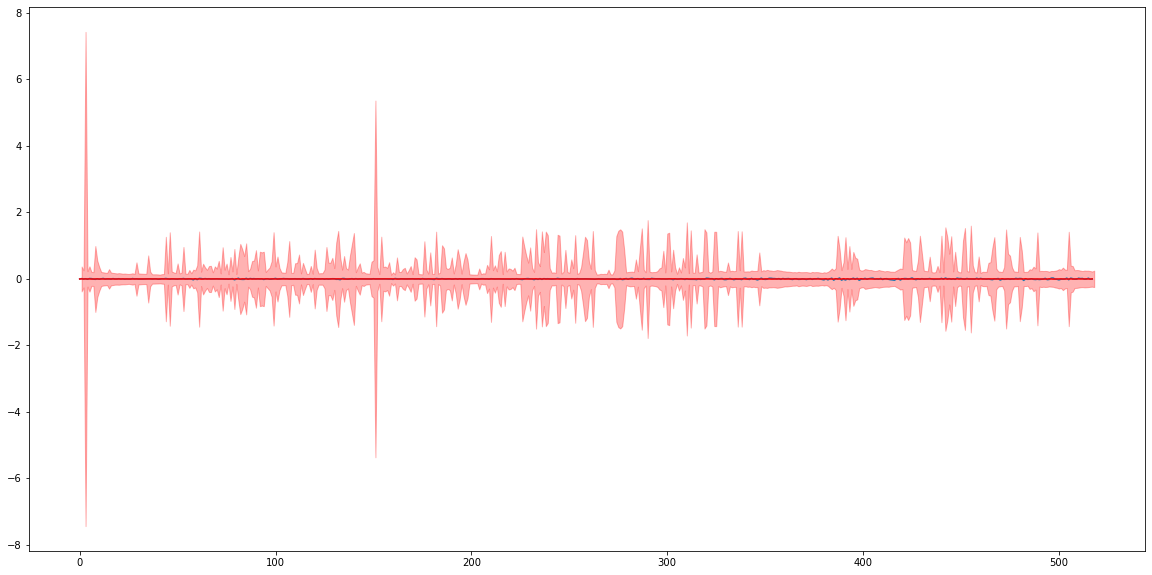

In [140]:
from sklearn.metrics import mean_squared_error

# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
x = range(1, len(predictions) + 1)
plt.plot(test)
plt.plot(predictions, color = "red")
plt.fill_between(x, y_lw, y_up,
             color='red', alpha=.3, label='2$\sigma$ Confidence level (95%)')

plt.show()

# REFERENCES

DUDEK, G. STD: A Seasonal-Trend-Dispersion Decomposition of Time Series. Journal of Latex Class Files. Vol. 14, N.8. August, 2015.

# APPENDIX